This is just continuing directly from notebook 1. 

In [10]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import gzip
import re
from pomegranate import *

# Import my packages.
%matplotlib inline
import matplotlib as mpl
%matplotlib notebook
%matplotlib notebook

import sys
from importlib import reload
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/insulators/bin')
from hic_jupyter import viewer
import hic_jupyter as hc

## Functions

Copying functions from notebook 1:

In [11]:
# Make sample data matrix.

def make_sample_data(files, genome_size, bin_size=500):
    num_bins = int(genome_size // bin_size)
    data = np.zeros((num_bins, len(files)))
    
    for i in range(0, len(files)):
        file = files[i]
        if (file[-2:] == 'gz'):
            f = gzip.open(file, 'rt')
        
        else:
            f = open(files[i], 'r')
        for line in f:
            line = line.rstrip()
            chr_, bin_, val = line.split()
            val = float(val)
            bin_ = int(bin_)
            data[bin_, i] = val

    return data

In [12]:
# Takes a list of coordinates (hand-called boundaries) and output from make_sample_data, returns
# matched data (essentiallly a slice of X_data) and labels (1 where boundary called, 0 elsewhere).

# Only for single chromosome at the moment.

def make_training_data(x, coordfiles, buffer=10, binsize=500):
    def process_coordfile(x, coordfile, buffer, binsize):
        y = np.zeros((x.shape[0]))
        min_ = np.inf
        max_ = -np.inf
        
        f = open(coordfile, 'r')
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ < min_):
                    min_ = bin_
                if (bin_ > max_):
                    max_ = bin_
                y[bin_] = 1
        training_data = x[(min_ - buffer):(max_ + buffer), :]
        class_labels = y[(min_ - buffer):(max_ + buffer)]
        f.close()
        return training_data, class_labels
    
    data, labels = process_coordfile(x, coordfiles[0], buffer, binsize)
    for i in range(1, len(coordfiles)):
        new_data, new_labels = process_coordfile(x, coordfiles[i], buffer, binsize)
        data = np.vstack((data, new_data))
        labels = np.hstack((labels, new_labels))
    
    return data, labels    


In [13]:
# Take hand-called coordinates and an insulation score data file, re-assign boundary 
# to local peak bin (if necessary) and also to adjacent bins if needed, return label
# array with bins in the hand-called areas labels 0 (not boundary) or 1 (boundary)
# and all other positions -1.

def labels_from_hand_calls(coord_files, ins_data, adjacent=2, stringency=0.66, binsize=500):
    labels = np.repeat(-1, ins_data.shape[0])
    for coordfile in coord_files:
        f = open(coordfile, 'r')
        bin_min = np.inf
        bin_max = -np.inf
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ > bin_max):
                    bin_max = bin_
                if (bin_ < bin_min):
                    bin_min = bin_
                    
                window_start = bin_ - adjacent
                window_end = bin_ + adjacent
                local_max = np.max(ins_data[window_start:(window_end+1)])
                thresh = local_max * stringency
                for i in range(window_start, window_end+1):
                    val = ins_data[i]
                    if (val >= thresh):
                        labels[i] = 0
        labels[bin_min:(bin_max+1)] += 1         
        f.close()
    return labels


In [14]:
# Load 1D coverage data.
def load_track_data(trackfile_path):
    """Load genomic track data."""
    track_binsize = 500
    track_data = {}
    with gzip.open(trackfile_path, 'rt') as infile:
        for line in infile:
            items = line.split()
            (chr_, bin_, val) = items
            chr_ = re.sub('chr', '', chr_)
            if (chr_ not in track_data):
                track_data[chr_] = np.zeros(int(1e8 / 500))
            bin_ = int(bin_)
            if (bin_ < len(track_data[chr_])):
                track_data[chr_][bin_] = float(val)
    return track_data

In [16]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_1_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_2_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_3_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_4_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_5_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_6_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_7_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_8_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_9_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_10_gap_0.txt.gz'
        ]
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_1.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_3_clickedcoords_2021-01-07-10.txt']
y = labels_from_hand_calls(c_files, X[:,2], adjacent=4)
y2 = y.copy()
y2 = y2.astype(str)
labeled = y2 != '-1'

<IPython.core.display.Javascript object>


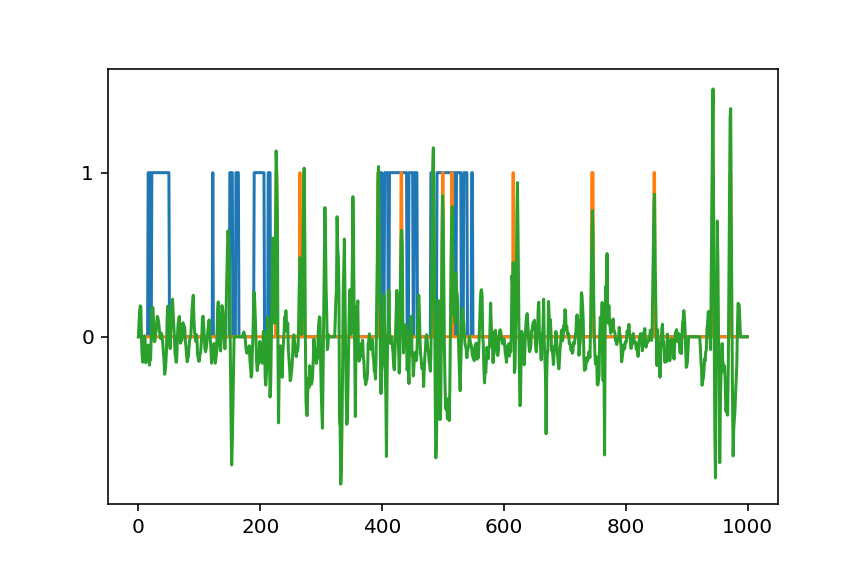

In [17]:
X2 = X.copy()[:,0:1]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


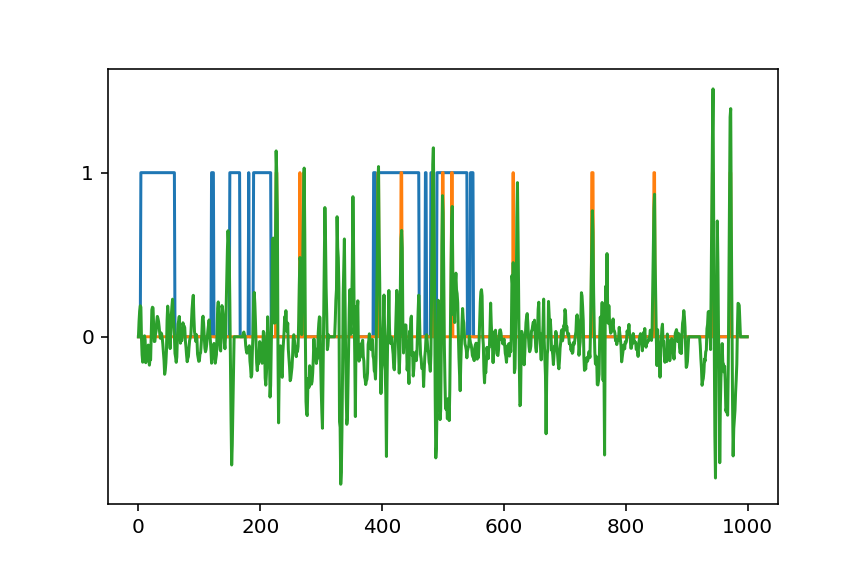

In [18]:
X2 = X.copy()[:,4:5]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


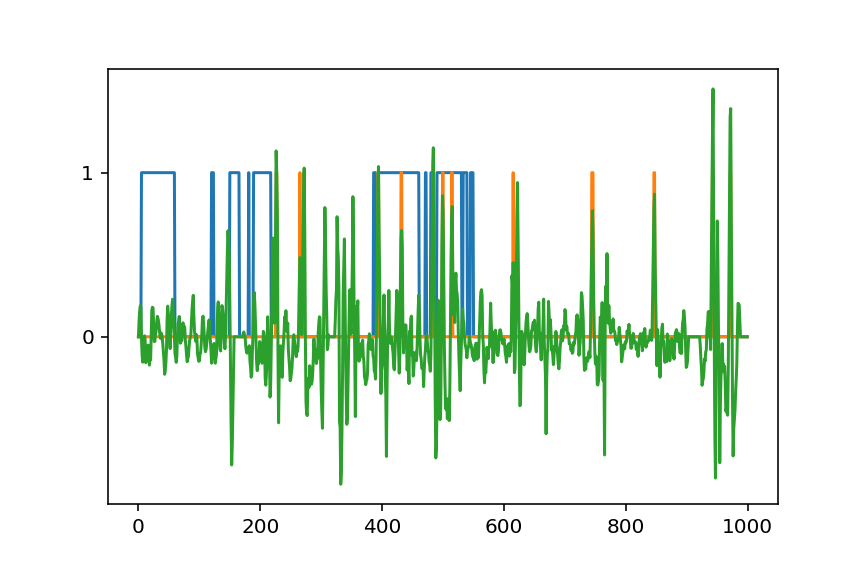

In [19]:
X2 = X.copy()[:,3:4]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


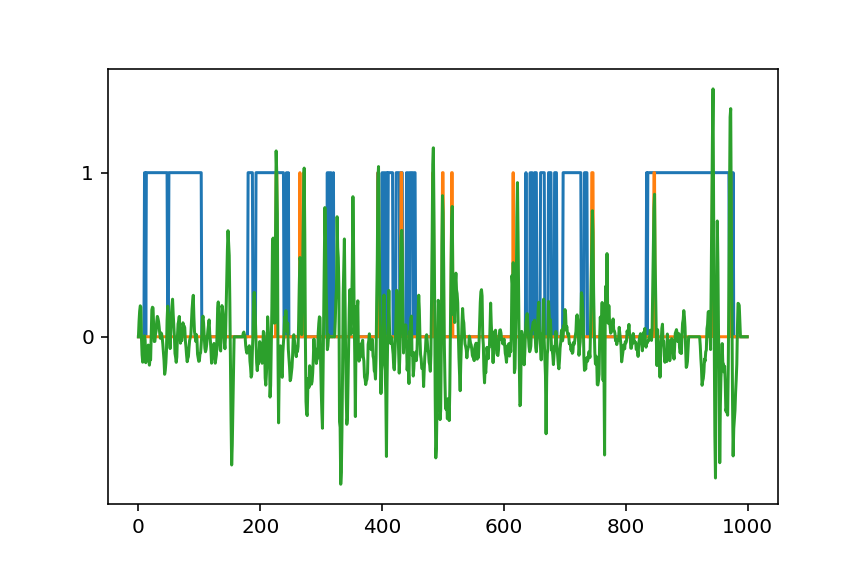

In [20]:
X2 = X.copy()[:,3:6]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


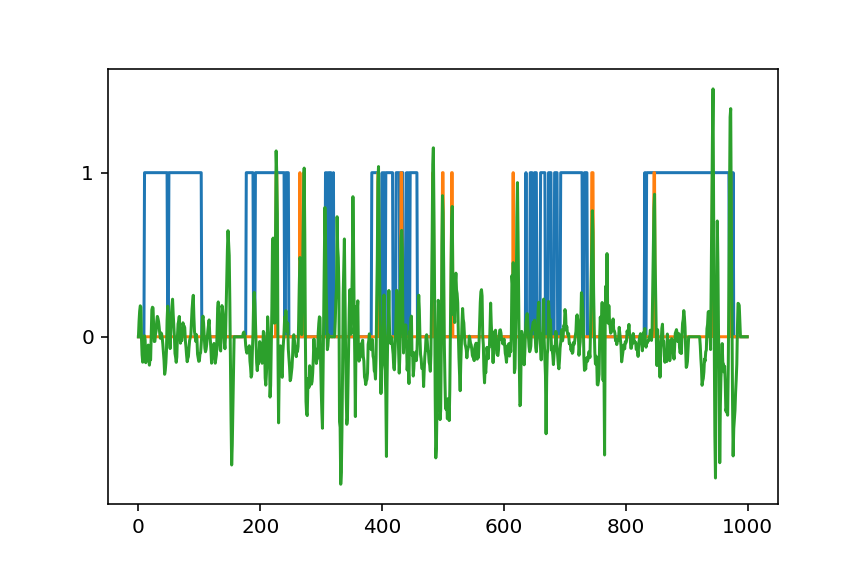

In [21]:
X2 = X.copy()[:,4:7]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [X2[labeled]], 
                                   labels= [y2[labeled]], state_names=['0','1'])

output = model.predict(X)

plt.plot(output[13000:14000])
plt.plot(y2[13000:14000])
plt.plot(X[13000:14000,3])

<IPython.core.display.Javascript object>


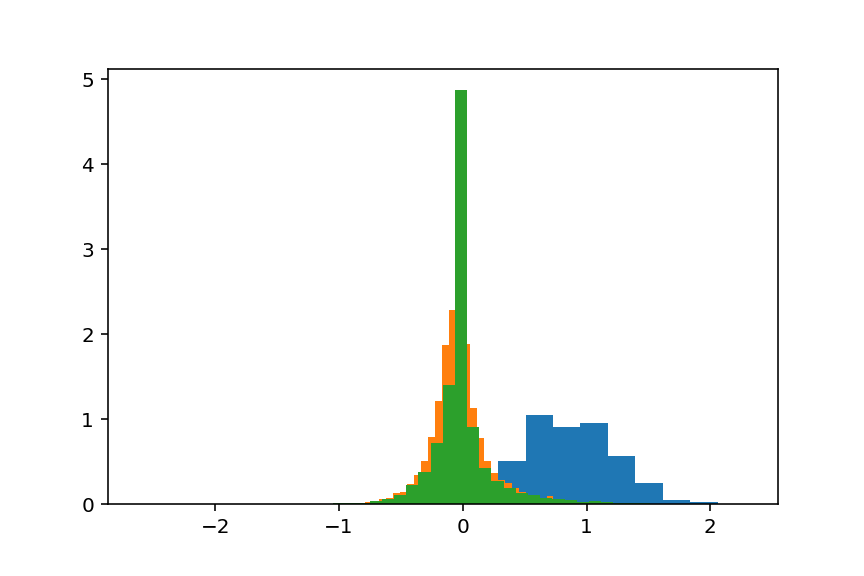

In [25]:
plt.hist(X[:,4][y == 1], density=True);
plt.hist(X[:,4][y == 0], bins=50, density=True);
plt.hist(X[:,4][y == -1], bins=50, density=True);
#?plt.hist

In [23]:
def flip(x):
    return -1 * (np.array(x) - 1)

<IPython.core.display.Javascript object>


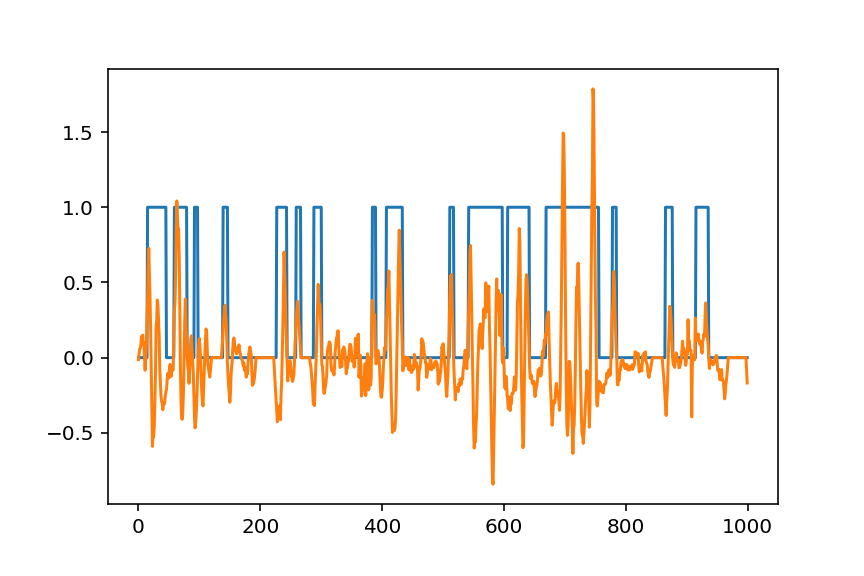

In [30]:
X2 = X.copy()[:,5:6]
x_train = X2[labeled]
y_train = y2[labeled].astype(int)

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [x_train], 
                                   labels= [y_train], state_names=['nb','b'])

output = model.predict(x_train, algorithm='viterbi')
start=1000
end=2000

plt.plot(flip(output)[start:end])
plt.plot(x_train[start:end,0])
#plt.plot(y_train[start:end])

In [ ]:
model.dense_transition_matrix()

### Where are we?

This looks to be working, but not to be especially great. Some ways to improve it are to have more/better training data, or to use better/different inputs.

Going to try doing some new hand-calling. Did it in three blocks covering ~4.2 Mb. Saved as training 2a through 2c.

In [ ]:
data_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked'
track_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks'
save_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R'
hc.viewer(data_folder, track_folder, save_folder)

In [28]:
c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,2], adjacent=4)
labeled = y != -1

<IPython.core.display.Javascript object>


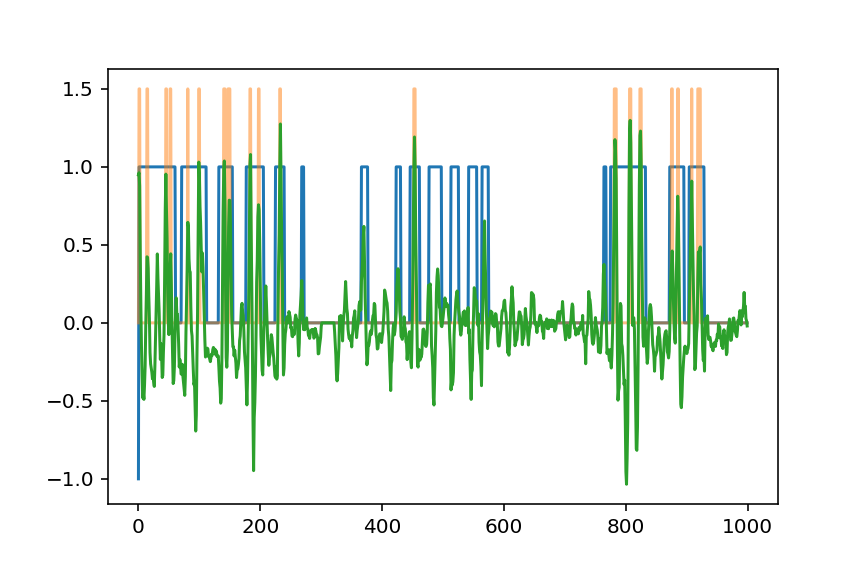

In [31]:
X2 = X.copy()[:,4:6]
y2 = y.copy()
x_train = X2[labeled]
y_train = y2[labeled]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [x_train], 
                                   labels= [y_train], state_names=['nb','b'])

output = model.predict(x_train, algorithm='viterbi')
start=0
end=1000

plt.plot(flip(output)[start:end])
plt.plot(y_train[start:end] * 1.5, alpha=0.5)
plt.plot(x_train[start:end,0])


## Adding protein

Let's add some ChIP datasets and see how this does.

In [32]:
def normcol(x):
    x_new = x.copy()
    for i in range(0, x.shape[1]):
        x_new[:,i] = (x_new[:,i] - np.mean(x_new[:,i])) / np.std(x_new[:,i])
    return x_new

<IPython.core.display.Javascript object>


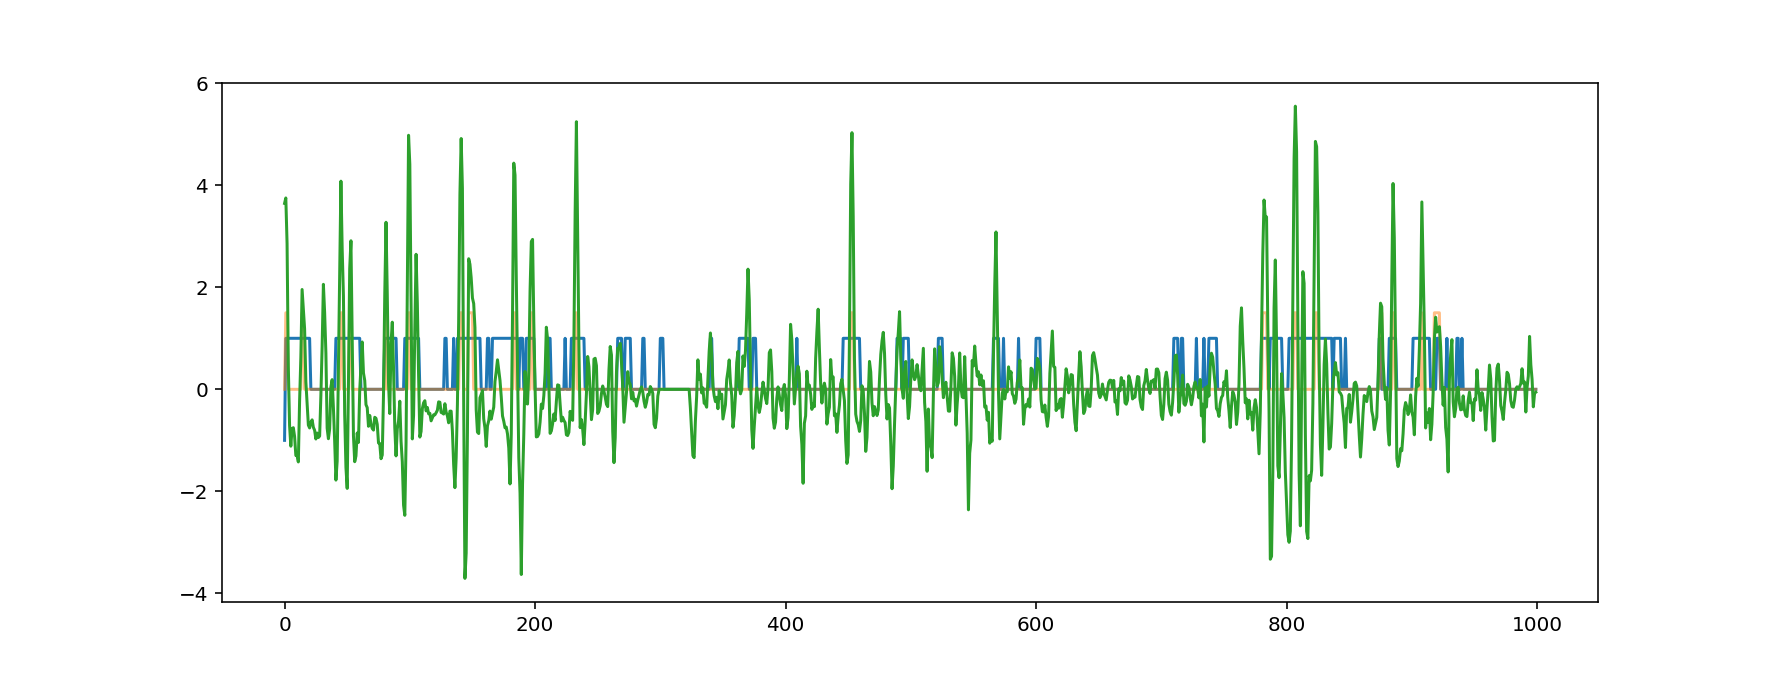

In [33]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_3_gap_0.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_4_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_5_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/wind_75_diff_6_gap_0.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/CP190.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/BEAF-32.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/dCTCF.txt.gz'
        ]
X = make_sample_data(files, 3e7)

X2 = normcol(X)
y2 = y.copy()
x_train = X2[labeled]
y_train = y2[labeled]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [x_train], 
                                   labels= [y_train], state_names=['nb','b'])

output = model.predict(x_train, algorithm='viterbi')
start=0
end=1000

plt.plot(flip(output)[start:end])
plt.plot(y_train[start:end] * 1.5, alpha=0.5)
plt.plot(x_train[start:end,0])

<IPython.core.display.Javascript object>


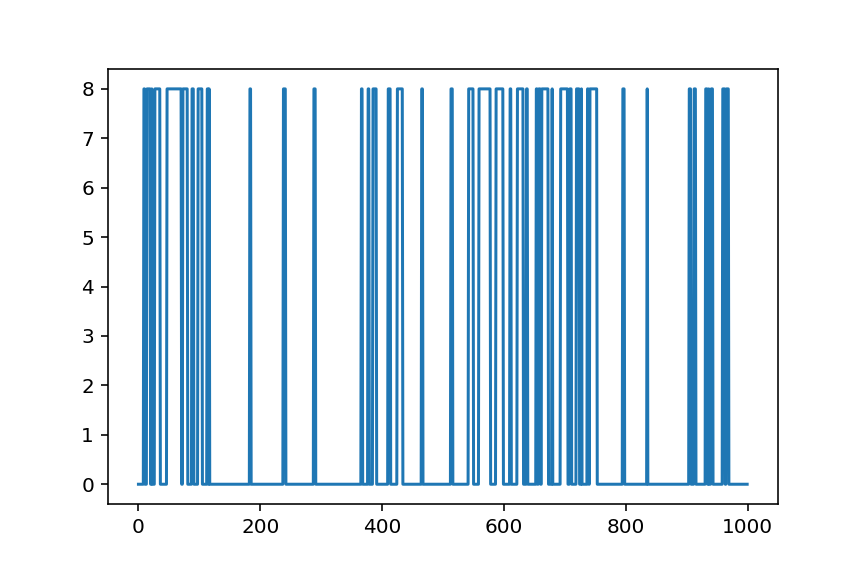

In [40]:
start=1000
end=2000
plt.plot(flip(output)[start:end]*8)
#plt.plot(y_train[start:end] * 1.5, alpha= )
#plt.plot(x_train[start:end,0])
#plt.plot(x_train[start:end,-3])

In [36]:
def normcol(x):
    x_new = x.copy()
    for i in range(0, x.shape[1]):
        x_new[:,i] = (x_new[:,i] - np.mean(x_new[:,i])) / np.std(x_new[:,i])
    return x_new

## Update

So this works ok, but seems to over-rely on the ChIP data. One thing that is notable is that the supervised HMM is a quite effective peak caller for the ChIP data (trained on Hi-C alone...that's interesting). That got me looking at the insulator scores, and I think I should revisit that. Namely, the way I take the derivative is probably not the optimal mathematical treatment. Looking at the raw directionality scores, the boundaries really should form screaming peaks if I get the derivative function right. They're extremely easy to pick out by eye. So let's revisit and play around.

## Revisiting insulation score

In [37]:
d75 = load_track_data('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/directionality_w75.txt.gz')
d75 = d75['2R']

In [38]:
import pandas as pd
testdir = pd.Series(d75[20000:20400])

<IPython.core.display.Javascript object>


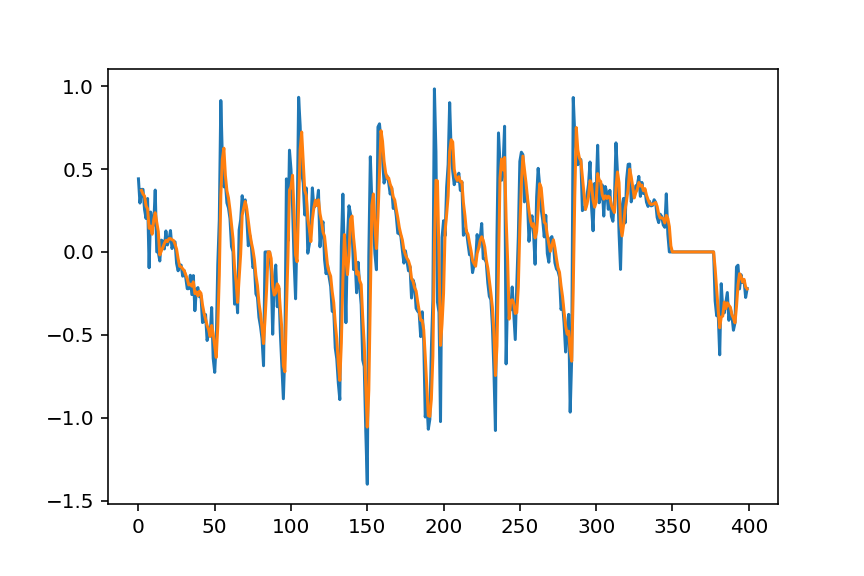

In [41]:
plt.plot(testdir)
plt.plot(testdir.rolling(3).mean())

<IPython.core.display.Javascript object>


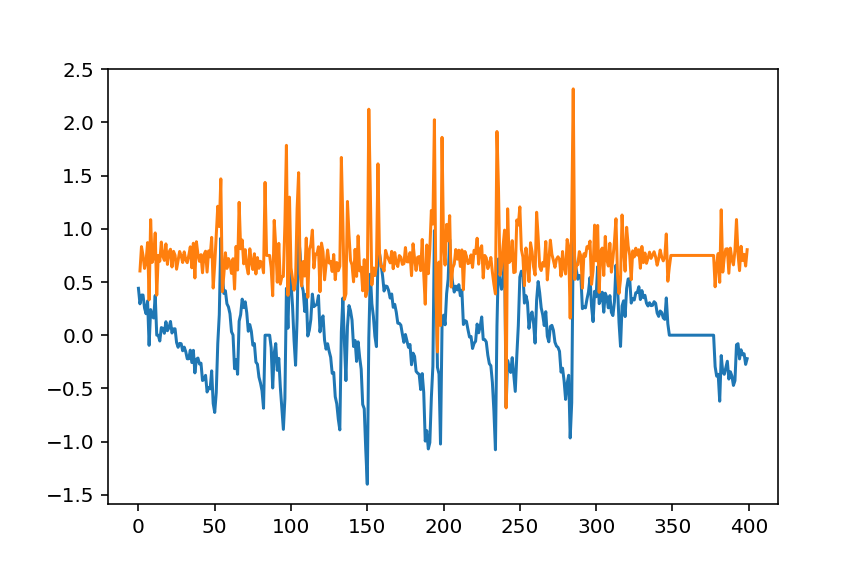

In [42]:
#a = testdir.rolling(2).mean()
a = testdir
b = a.diff()
plt.plot(a)
plt.plot(b+0.75)

<IPython.core.display.Javascript object>


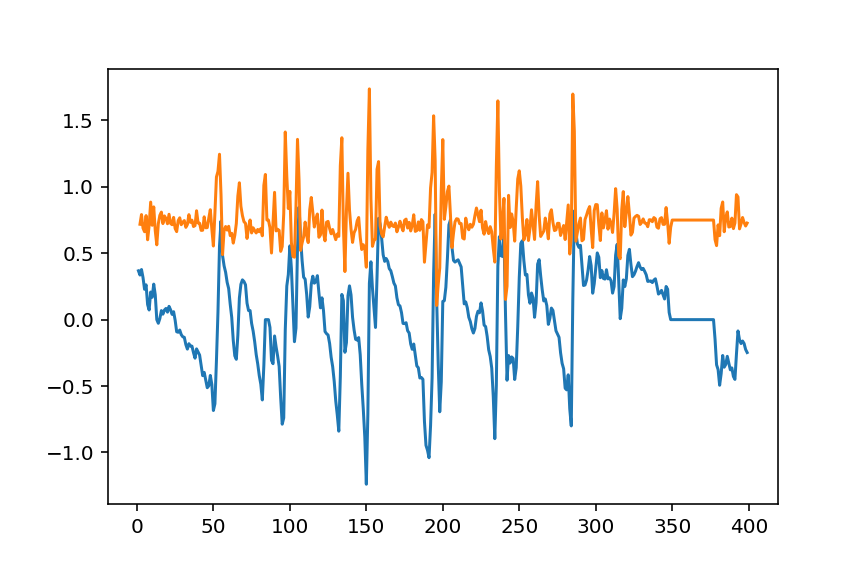

In [43]:
a = testdir.rolling(2).mean()
b = a.diff()
plt.plot(a)
plt.plot(b+0.75)

<IPython.core.display.Javascript object>


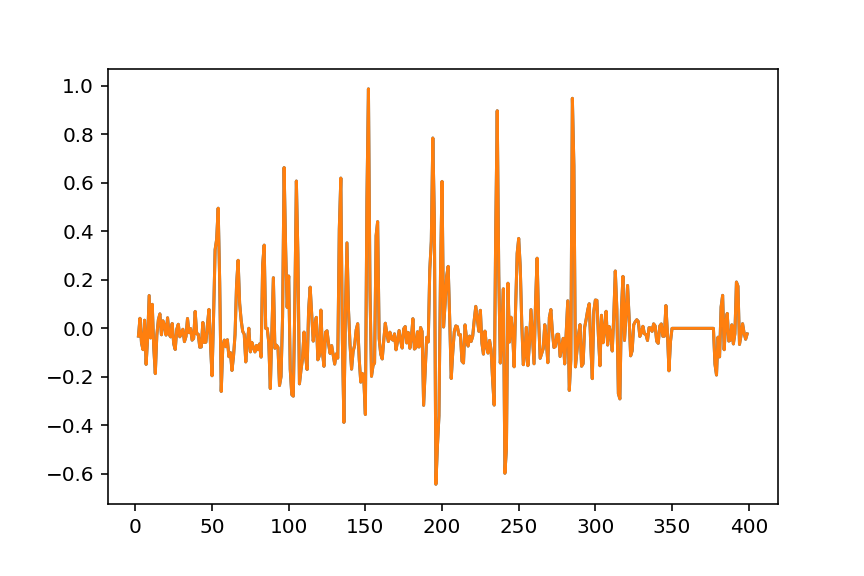

In [44]:
# Center does nothing for 2, does shift by 1 for 3 (makes sense).
a = testdir.rolling(2).mean()
b = a.diff()
c = testdir.rolling(2, center=True).mean()
d = c.diff()
plt.plot(b)
plt.plot(d)

<IPython.core.display.Javascript object>


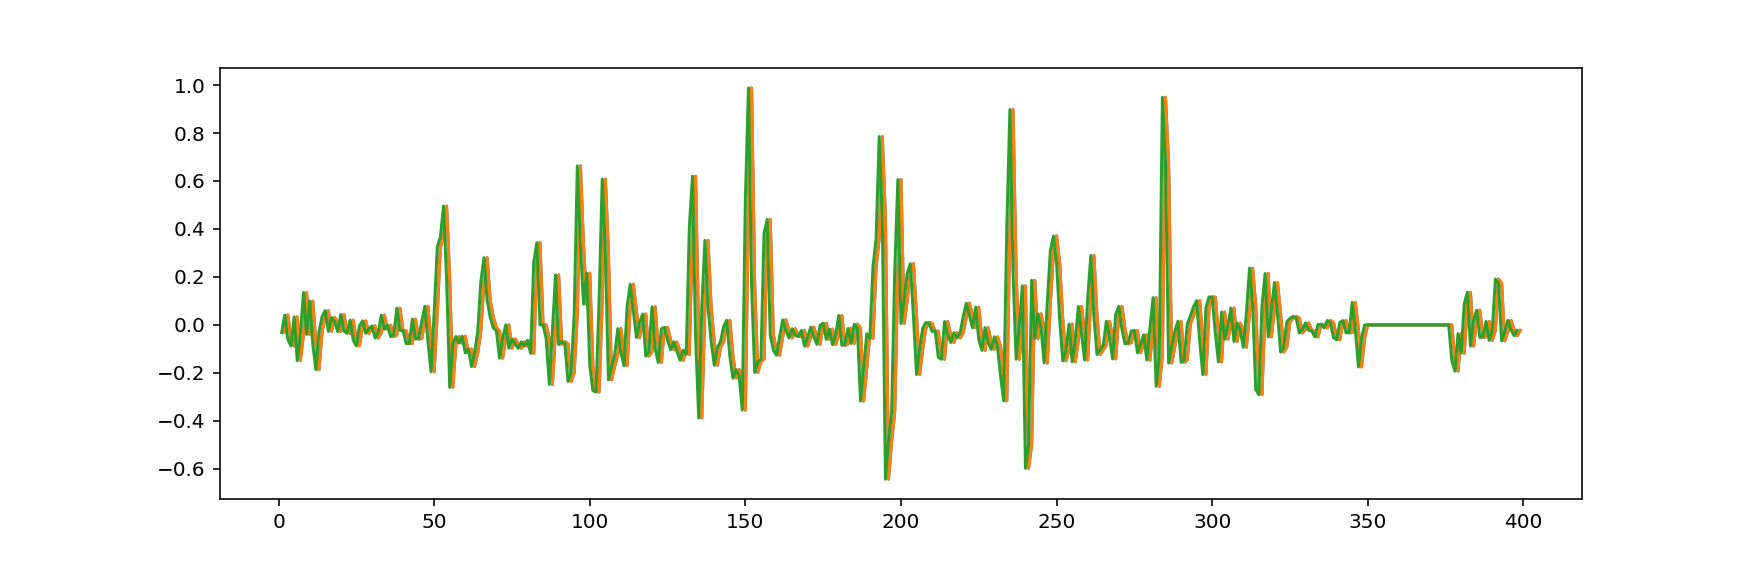

In [46]:
# Is everything being shifted right? Yes, by one bin.
a = testdir.rolling(2).mean()
b = a.diff()
c = a.diff(1)
d = -1*a.diff(-1)
plt.plot(b)
plt.plot(c)
plt.plot(d)


<IPython.core.display.Javascript object>


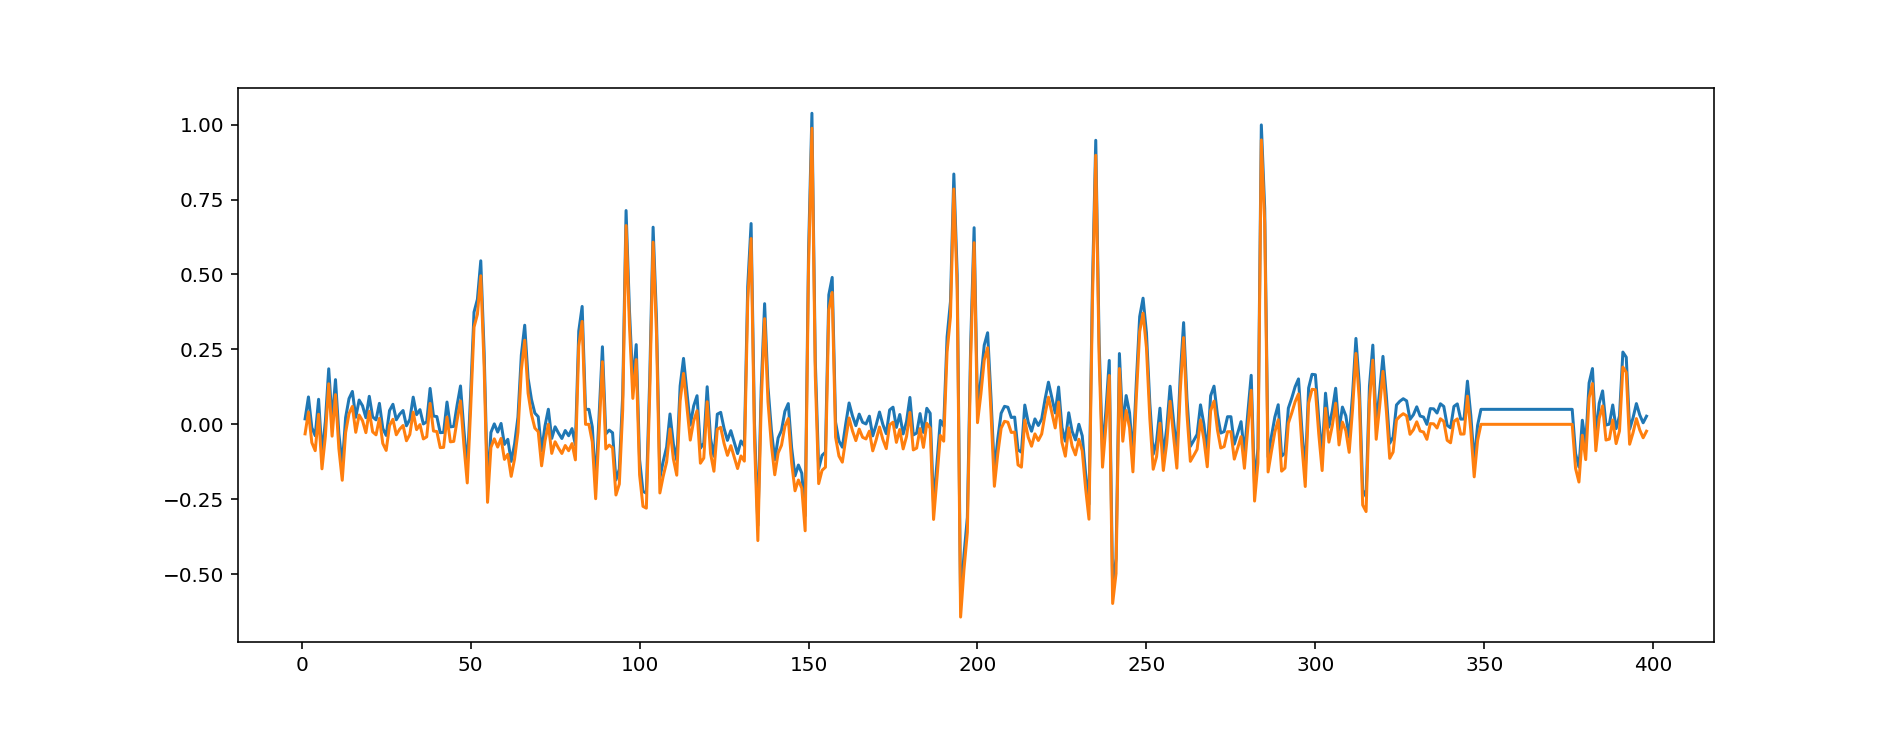

In [47]:
# Shift function fixes.
a = testdir.rolling(2).mean()
c = a.diff(1)
c = c.shift(-1)
d = -1*a.diff(-1)
plt.plot(c+0.05)
plt.plot(d)



<IPython.core.display.Javascript object>


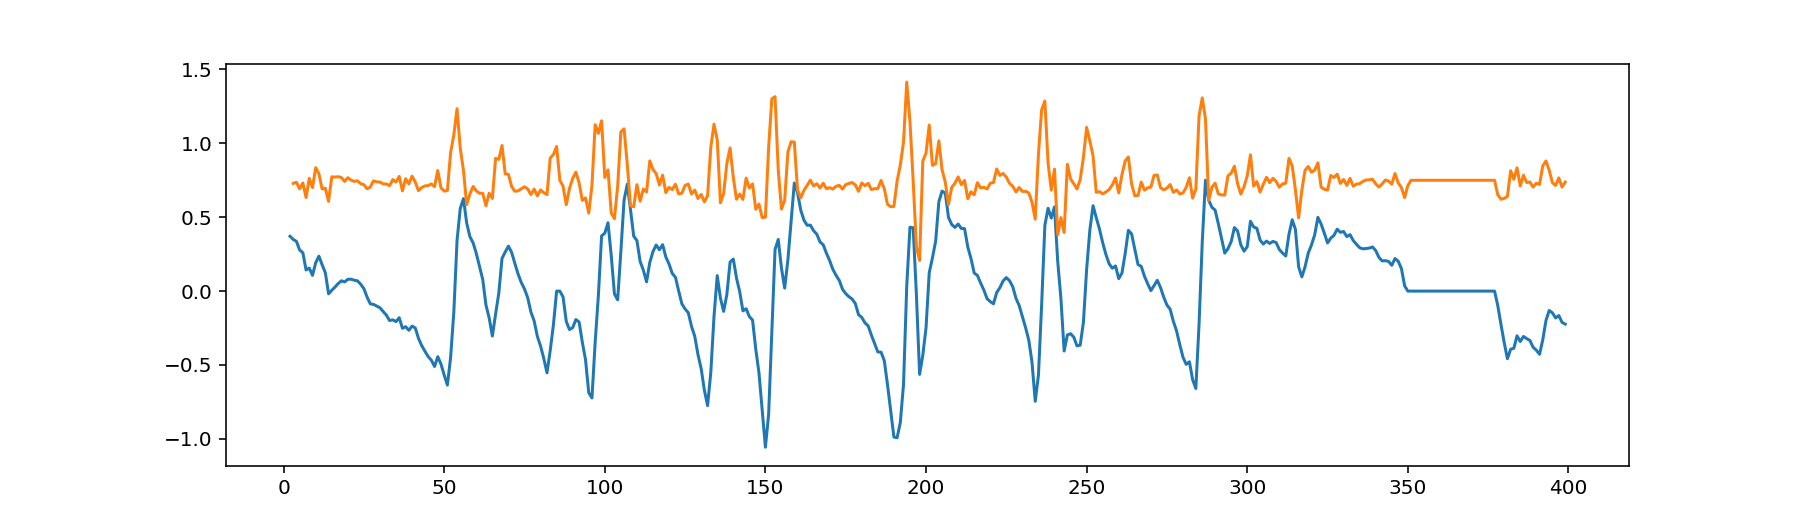

In [50]:
a = testdir.rolling(3).mean()
b = a.diff()
plt.plot(a)
plt.plot(b+0.75)

<IPython.core.display.Javascript object>


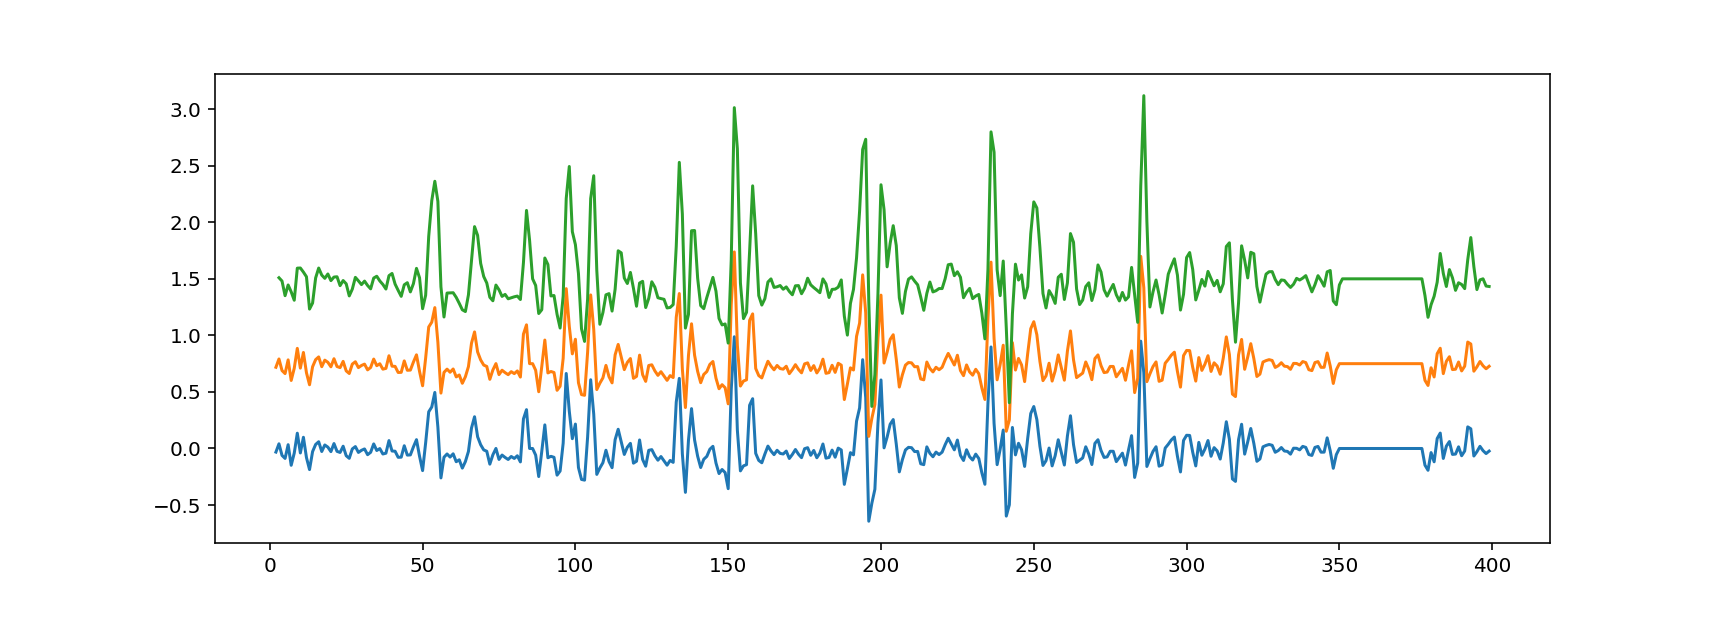

In [51]:
# Testing how diff function works
a = testdir.rolling(2).mean()
b = a.diff()
c = a.diff(1)
d = a.diff(2)
plt.plot(b)
plt.plot(c+0.75)
plt.plot(d+1.5)

This looks a lot better. I think the rolling average with a window size of 2 seems to smooth out some of the noise and gives really clear peaks that should be simple to call. Need to rewrite the boundary score script to use this and test it out:

In [52]:
import re
import os
import pandas as pd

def boundary_score(infolder, outfilepath, windowsize, binsize, mode='directionality', diff_window=1, leftright_dist=4, nan_buffersize=3):
    
    def not_valid_file(filename):
        if (re.search('txt.gz', filename)):
            name_items = re.sub('.txt.gz', '', filename)
            if (len(name_items.split('_')) == 4):
                return False
        return True
    
    def add_panel(infolder, filename, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize):
        min_nonnan = 0.5 * nan_buffersize
        if not_valid_file(filename):
            return
        x = np.genfromtxt(os.path.join(infolder, filename))
        #x[np.isnan(x)] = 0.5
        x[x == 0] = 0.5
        
        name_items = re.sub('.txt.gz', '', filename)
        chr_, start, end, file_binsize = name_items.split('_')
        start_bin = int(int(start) / binsize)
        end_bin = int(int(end) / binsize)
        
        if (int(file_binsize) == binsize):
            if (chr_ not in scores):
                scores[chr_] = np.zeros(chr_max_bins)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = end_bin
            if (end_bin > chr_maxes[chr_]):
                chr_maxes[chr_] = end_bin
                
            panel_size_bins = end_bin - start_bin
            for n in range(windowsize, panel_size_bins - windowsize + 1):
                left_window = x[n, (n-windowsize):n]
                right_window = x[n, (n+1):(n+windowsize+1)]
                if ((np.count_nonzero(~np.isnan(left_window[(-1 * nan_buffersize):])) > min_nonnan) and
                    (np.count_nonzero(~np.isnan(right_window[:nan_buffersize])) > min_nonnan)):
                    mean_left = np.nanmean(left_window)
                    mean_right = np.nanmean(right_window)
                    logratio = np.log(mean_right / mean_left)
                    genome_bin = start_bin + n
                    scores[chr_][genome_bin] = logratio
    chr_max_size = 1e8
    chr_max_bins = int(chr_max_size // binsize)
    chr_maxes = {}
    scores = {}
    files = os.listdir(infolder)
    
    for file in files:
        add_panel(infolder, file, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize)
        
    outfile = open(outfilepath, 'w')
    for chr_ in chr_maxes.keys():
        if mode == 'derivative':
            roll_avg = pd.Series(scores[chr_]).rolling(2).mean()
            # Because differences are subtracted from the left, we need rolling averages assigned
            # to the left as well. There's no way to do that in rolling function, so series is  
            # manually shifted 1 position to left.
            roll_avg = roll_avg.shift(-1)
            scores[chr_] = roll_avg.diff(diff_window)
        
        elif mode == 'leftright':
            shifted = pd.Series(scores[chr_]).shift(leftright_dist)
            scores[chr_] = shifted
        
        for bin_ in range(0, chr_maxes[chr_]):
            score = scores[chr_][bin_]
            if (score != 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(score) + '\n')
    outfile.close()

In [ ]:
boundary_score('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt',
              75,500, 'derivative')

In [ ]:
hc.viewer(data_folder, track_folder, save_folder)

Looks terrific. Let's redo the data and training data with this file:

In [54]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X, adjacent=4)
labeled = y != -1

In [ ]:
start = 0
end = 1000
plt.plot(y[labeled][start:end])
plt.plot(X[labeled][start:end])


OK, this looks outstanding. Let's try some learning on it!

In [ ]:
x_train = X[labeled]
y_train = y[labeled]

model = HiddenMarkovModel.from_samples(NormalDistribution, 2, [x_train], 
                                   labels= [y_train], state_names=['nb','b'])

output = model.predict(x_train, algorithm='viterbi')
start=0
end=1000

plt.plot(flip(output)[start:end])
plt.plot(y_train[start:end] * 1.5, alpha=0.5)
plt.plot(x_train[start:end,0])

Well that's pretty awful. I mean it gets most of the hand-called boundaries, but it also calls a bunch of minor peaks and merges peaks. I'm curious as to why the learning is so bad...obviously it's getting the transition matrix wrong — there should essentially never be more than two boundary bins in a row. 

I can think of a few things to do. One would be to manually set the HMM. Another is to use a different type of modeling. The issue there is that if I want to call boundaries on the Hi-C data alone, anything else isn't going to work differently from a straight threshold with a single data input. Is there another 1D data input that could be informative? Maybe the raw directionality at + some bins and - some bins?

In [ ]:
boundary_score('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_left4.txt',
              75,500, 'leftright', leftright_dist=4)

In [55]:
boundary_score('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_right4.txt',
              75,500, 'leftright', leftright_dist=-4)

KeyboardInterrupt: 

### Interlude: boundary size

It occurs to me that it's a little surprising that using 1-bin differences (see above result without rolling average) actually works. This means we get significant changes in left-bias to right-bias between single 500 bp bins. I realized that we could say something about boundary size from these data.

So basically, there must be some "size" to a boundary: some stretch of chromatin that sits between two domains and isn't part of (doesn't preferentially contacct) either. If there weren't, we'd have adjacent nucleotides with opposite domain membership, and this seems absurd. So if we assume that there exist some boundary regions of size >1, we can sketch out how boundaries of different sizes would look in 500 bp (or any arbitrary resolution) Hi-C data. When considering directionality, a boundary looks like a transition from a negative peak on the left to a positive peak on the right. The question is whether there are intermediate points: as we move from left to right, do we find bins with intermediate (between the negative and positive peak values) directionality?

Three general cases make distinct predictions:

1) Boundary much smaller than bin size. Depending on where the boundary sits relative to bin divisions, there could be no intermediate points (boundary sits at/near bin boundary), two intermediate points (boundary spans the bin boundary), or one intermediate point (boundary sits within one bin). Examples of sharp transitions without intermediates would be diagnostic of this situation.

2) Boundary similar size to bin. There will be always intermediate points, but not necessarily any neutral (no left-right bias) bins. If the boundary is approx. centered on the bin boundary, it will produce an intermediate left-biased and an intermediate right-biased bin, but no unbiased bin.

3) Boundary larger than bin: There should always be at least one neutral bin.

Let's see!

In [56]:
direc = load_track_data('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/directionality_w75.txt.gz')
idxs = np.where(y==1)

<IPython.core.display.Javascript object>


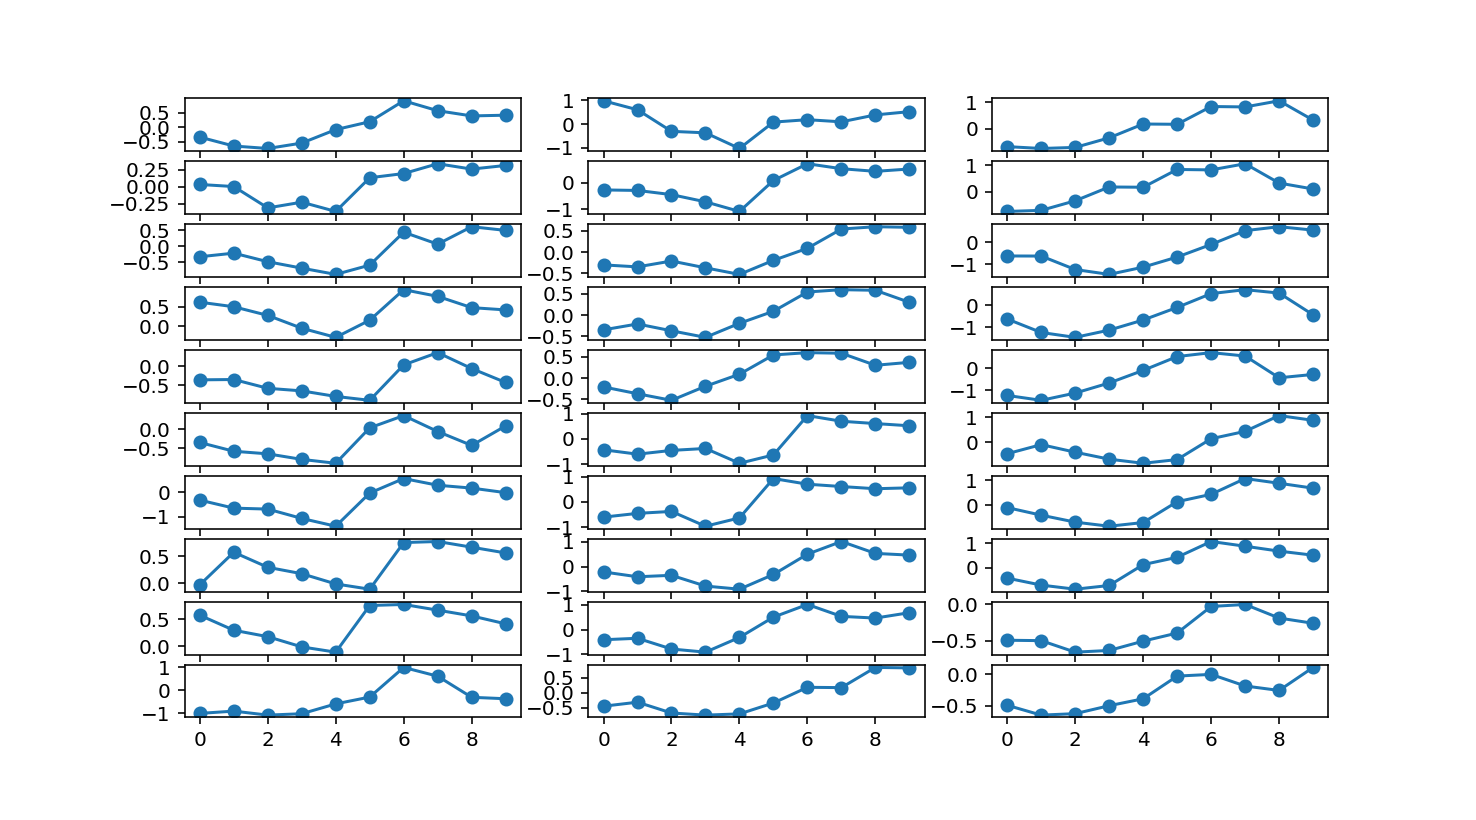

In [57]:
fig, ax = plt.subplots(10,3)
for i in range(0,30):
    idx = int(idxs[0][i])
    row = i % 10
    col = int(i / 10)
    ax[row][col].plot(direc['2R'][(idx-5):(idx+5)], marker="o")

This looks pretty clearly like case 1: there are some obvious cases that lack intermediate points. I realize that the case of closely-spaced boundaries may confound some of this, and is likely responsable for some of the features on the right (with many intermediate points. I'm going to re-do some hand calling to select boundaries that are very clear and that do not have nearby boundaries.

In [ ]:
hc.viewer(data_folder, track_folder, save_folder)

In [58]:
y2 = labels_from_hand_calls(['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/boundary_size_set_clickedcoords_2021-02-03-6.txt'], X[:,0], adjacent=4)
idxs = np.where(y2==1)

<IPython.core.display.Javascript object>


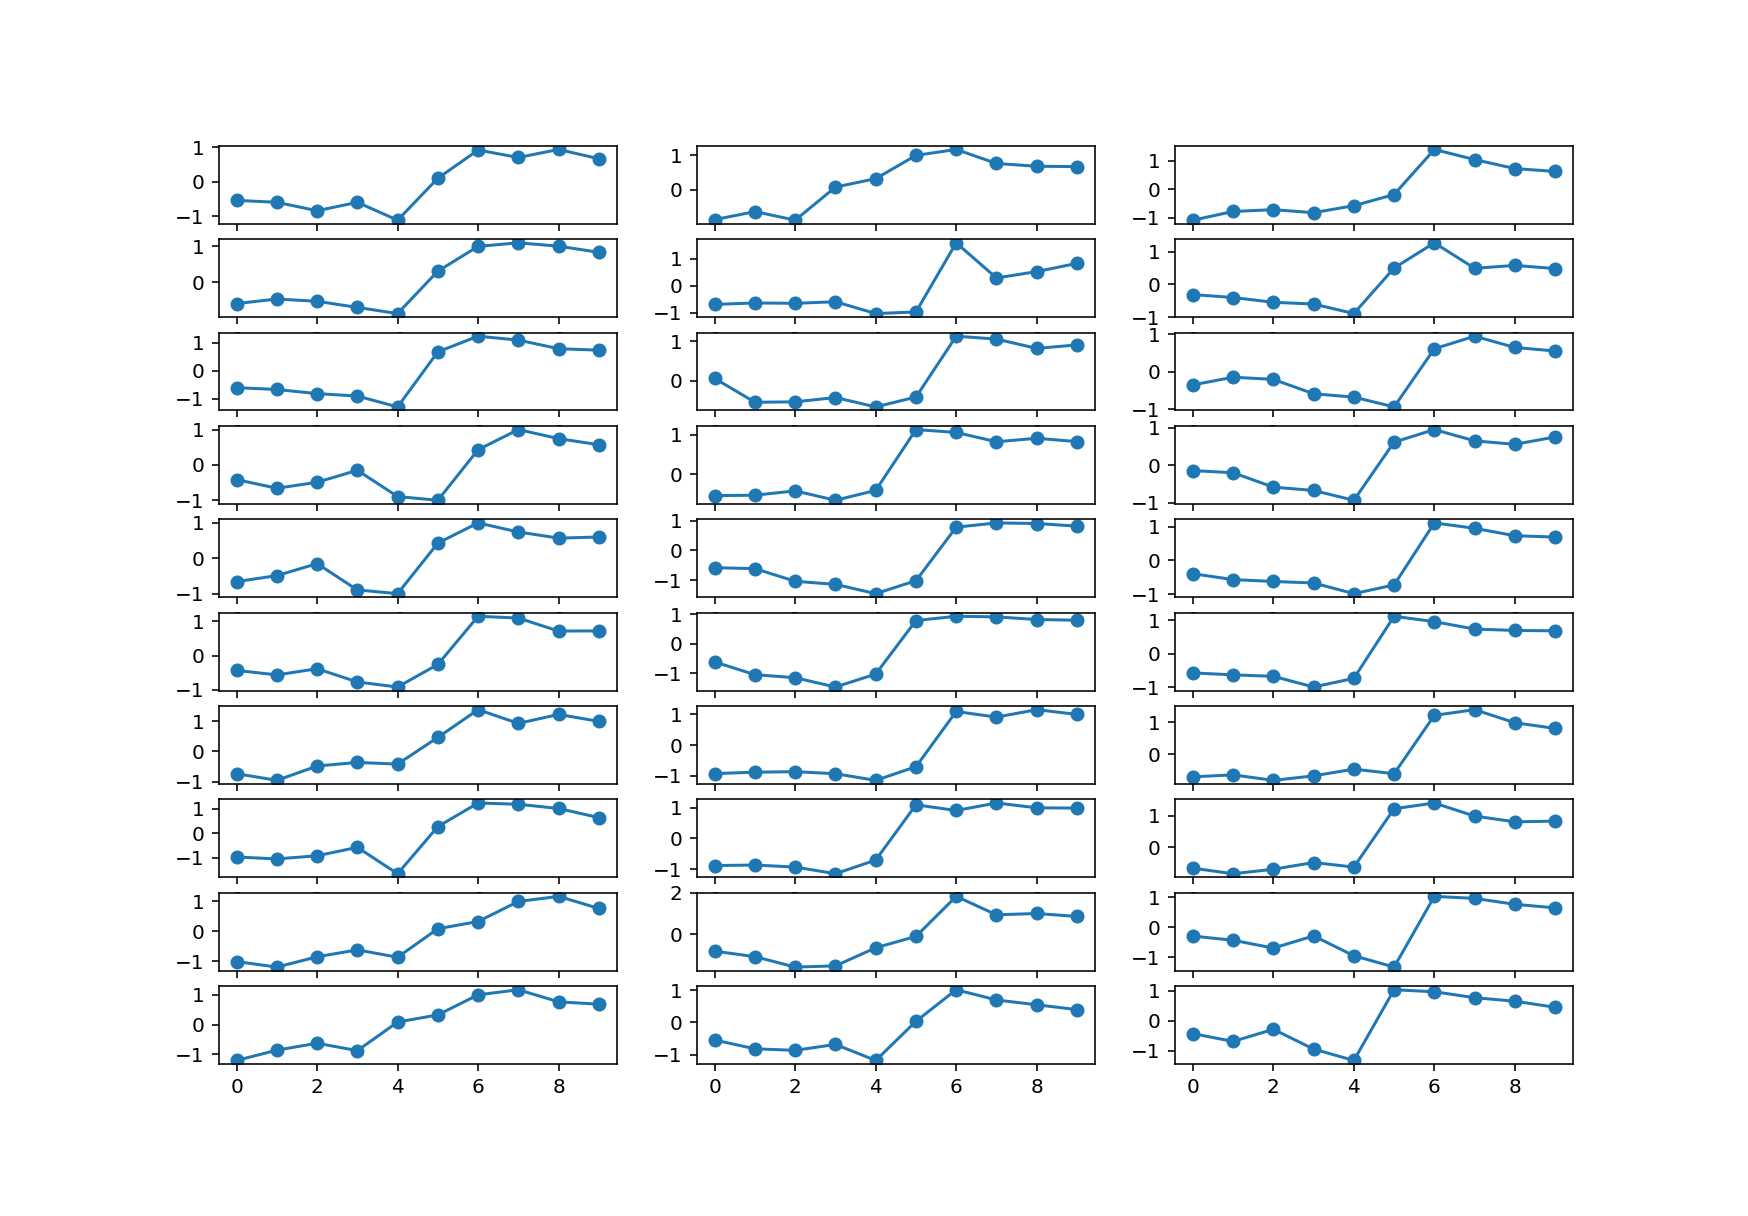

In [59]:
fig, ax = plt.subplots(10,3)
for i in range(0,30):
    idx = int(idxs[0][i])
    row = i % 10
    col = int(i / 10)
    ax[row][col].plot(direc['2R'][(idx-5):(idx+5)], marker="o")

Well that looks pretty dispositive. This looks exactly like scenario 1, which a number of cases lacking intermediates mixed with some with intermediates. This is consistent with boundaries being less than 500 bp. 

## Interlude done.

OK, back to reality. I need to check that the left-right tracks are correct.

In [60]:
left = load_track_data('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_left4.txt.gz')
right = load_track_data('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_right4.txt.gz')

<IPython.core.display.Javascript object>


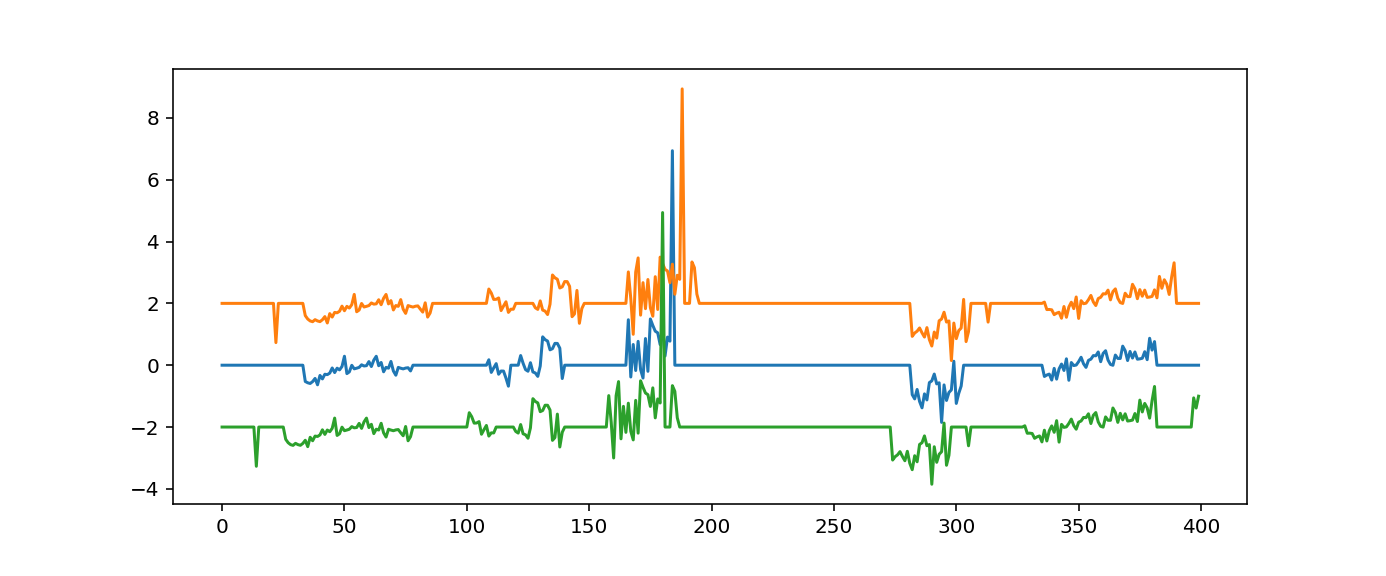

In [61]:
start, end = (5000, 5400)
plt.plot(direc['2R'][start:end])
plt.plot(left['2R'][start:end]+2)
plt.plot(right['2R'][start:end]-2)

The tracks are slightly different...maybe masked versus unmasked? Perhaps the original directionality (unshifted) track has some averaging. Not totally sure but it's minor. I can revisit the details if needd. Overall it checks out -- the tracks are properly shifted.

In [62]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_left4.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_right4.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

<IPython.core.display.Javascript object>


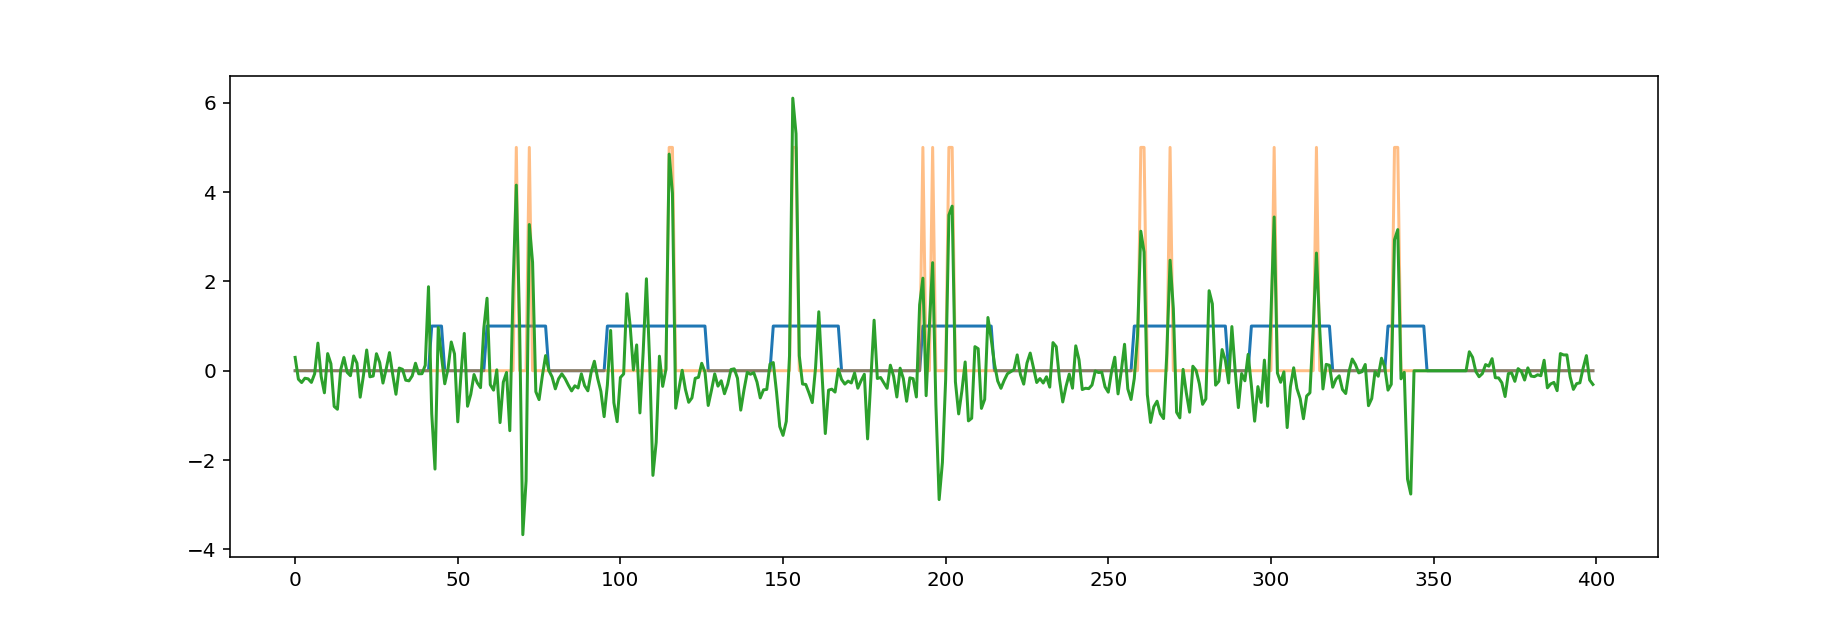

In [63]:
#x_train = normcol(X[labeled])
x_train = normcol(X[labeled])
y_train = y[labeled]

model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, 2, [x_train], 
                                   labels= [y_train], state_names=['nb','b'])

output = model.predict(x_train, algorithm='viterbi')
start=5000
end=5400

plt.plot(flip(output)[start:end])
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[start:end,0])

Well this is just awful performance. I don't understand why it insists on making larger blocks when the training set doesn't have anything like that. I would like to try some new models, but I'm also curious about "training" the model manually. I'll give that a run just to see.

I need the means, variances, and transition probabilities from the training data.

In [64]:
# Transitions.
orig = pd.Series(y_train)
shift = orig.shift(-1)

num_0 = np.count_nonzero(orig == 0)
num_01 = np.count_nonzero((orig == 0) & (shift == 1))
print(num_01 / num_0)

num_1 = np.count_nonzero(orig == 1)
num_10 = np.count_nonzero((orig == 1) & (shift == 0))
print(num_10 / num_1)

0.026695898890895024
0.6592356687898089


<IPython.core.display.Javascript object>


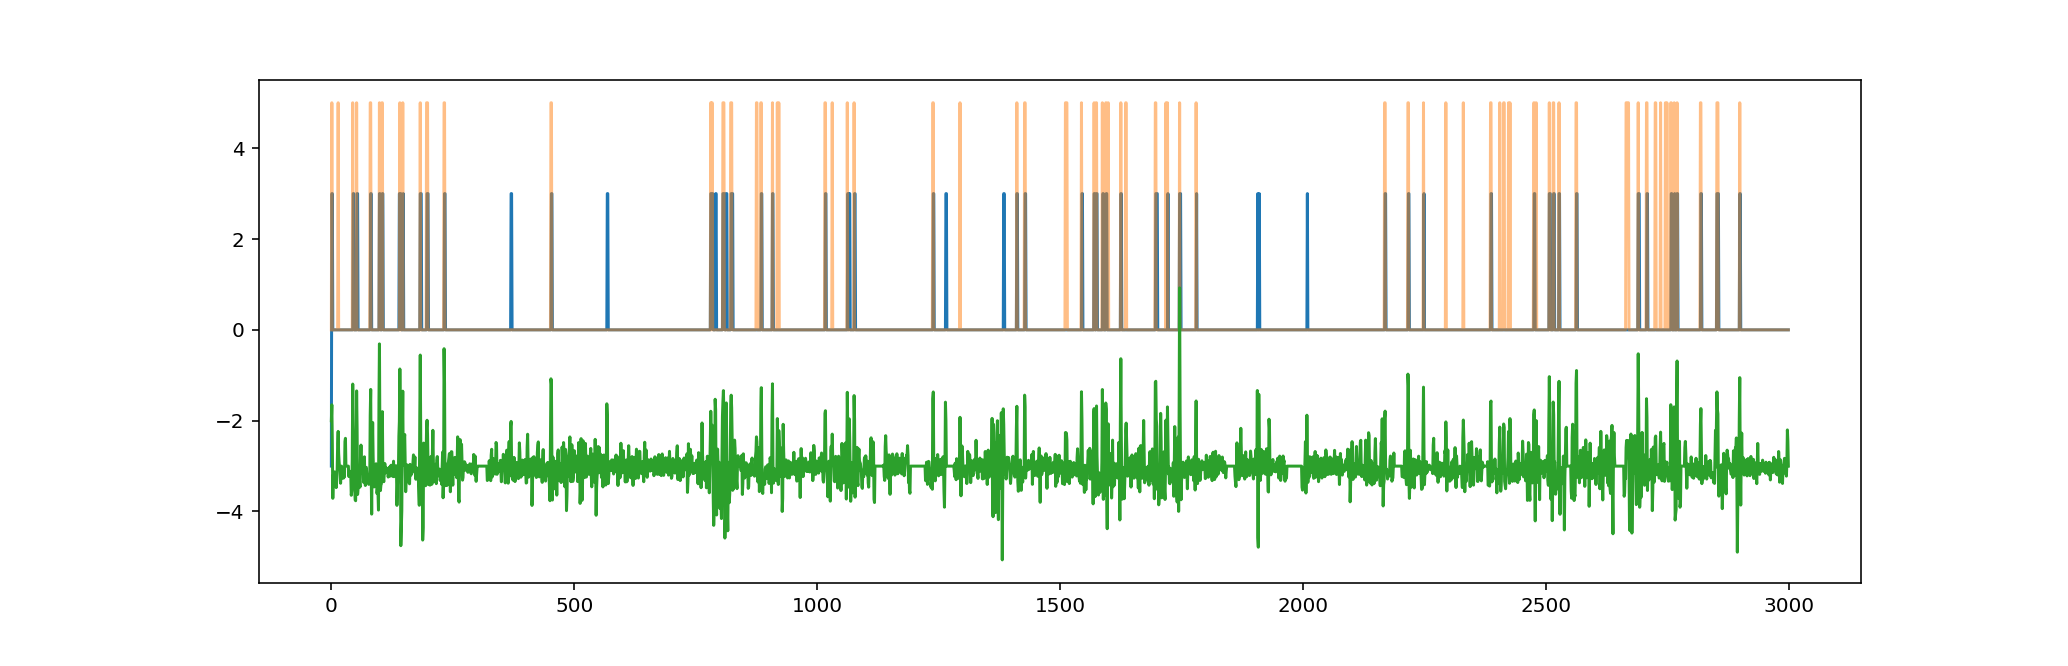

In [120]:
d_b = MultivariateGaussianDistribution.from_samples(x_train[y_train.astype(bool)])
d_nb = MultivariateGaussianDistribution.from_samples(x_train[~y_train.astype(bool)])

s_nb = State(d_nb, name='notboundary')
s_b = State(d_b, name='boundary')

model = HiddenMarkovModel()
model.add_states(s_b, s_nb)
model.add_transition(model.start, s_b, 0.5)
model.add_transition(model.start, s_nb, 0.5)
model.add_transition(s_nb, s_nb, 0.974 )
model.add_transition(s_nb, s_b, 0.026 )
#model.add_transition(s_b, model.end, 0.001)
model.add_transition(s_b, s_b, 0.34)
model.add_transition(s_b, s_nb, 0.66)
model.bake()

output = model.predict(x_train, algorithm='viterbi')
start=0
end=3000

plt.plot(flip(output)[start:end]*3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

Well this just looks excellent. What the hell? Why did it learn so badly? I guess it's worth understanding the labeling alrogithm better at some point. For now this seems like a great model. I wonder how it does using just the derivative?

<IPython.core.display.Javascript object>


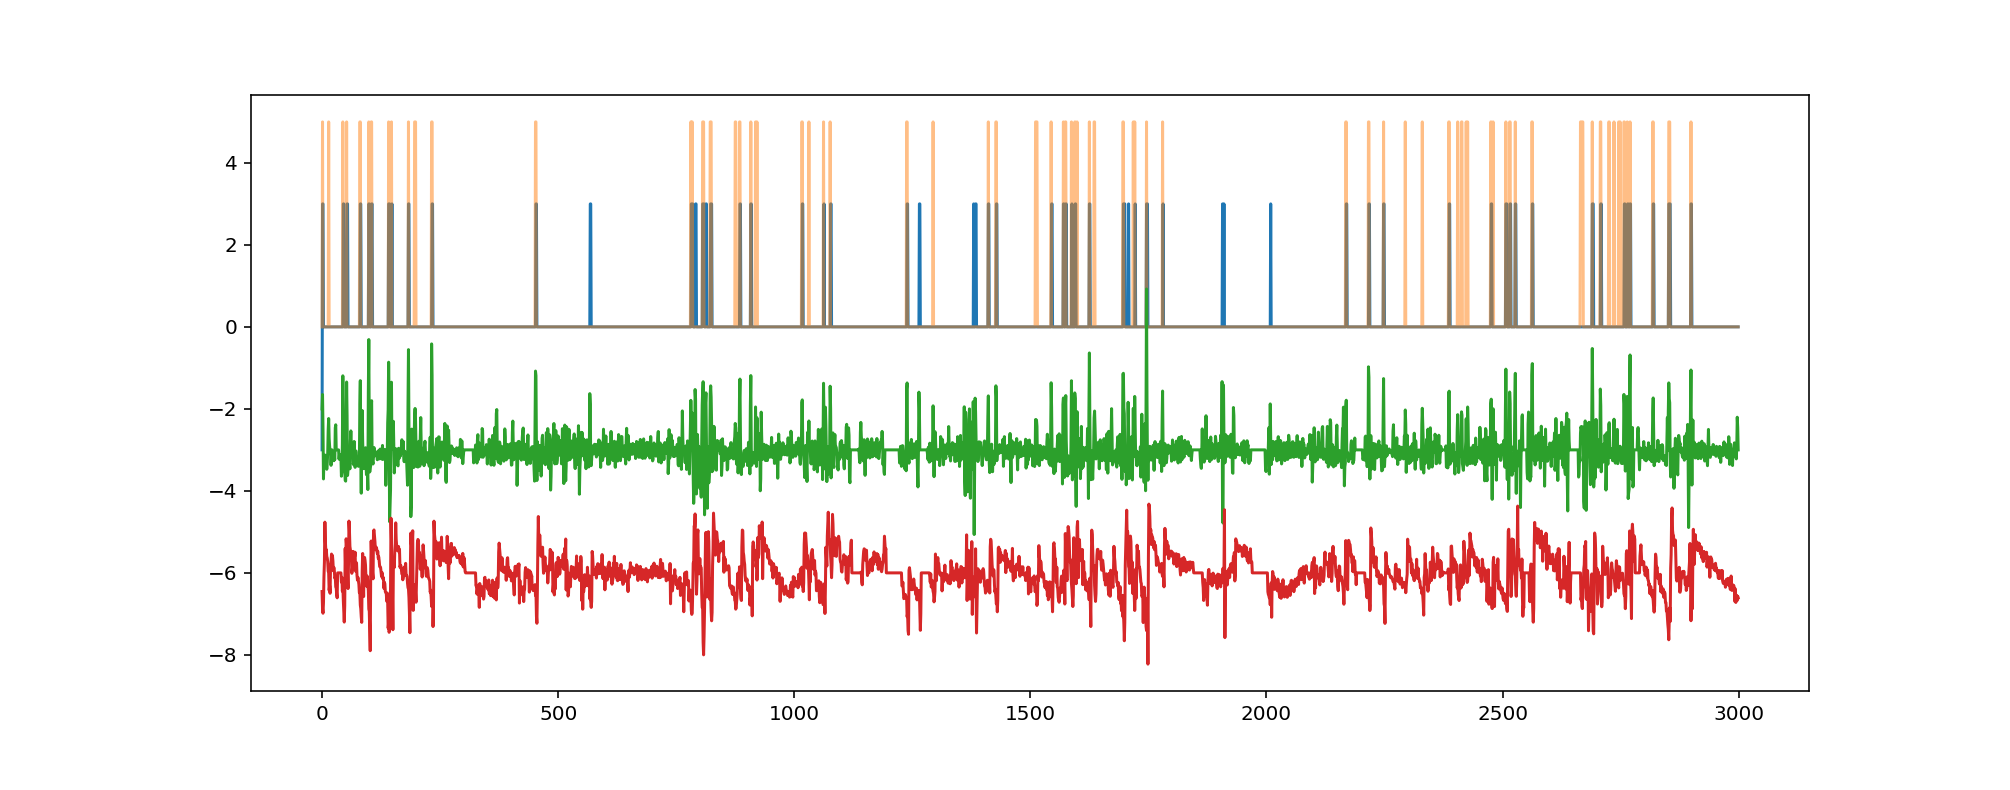

In [121]:
d_b = NormalDistribution.from_samples(x_train[y_train.astype(bool)][:,0:1])
d_nb = NormalDistribution.from_samples(x_train[~y_train.astype(bool)][:,0:1])
s_nb = State(d_nb, name='notboundary')
s_b = State(d_b, name='boundary')

model2 = HiddenMarkovModel()
m = model2
m.add_states(s_b, s_nb)
m.add_transition(m.start, s_b, 0.5)
m.add_transition(m.start, s_nb, 0.5)
m.add_transition(s_nb, s_nb, 0.974 )
m.add_transition(s_nb, s_b, 0.026 )
#model.add_transition(s_b, model.end, 0.001)
m.add_transition(s_b, s_b, 0.34)
m.add_transition(s_b, s_nb, 0.66)
m.bake()

output = model2.predict(x_train[:,0:1], algorithm='viterbi')
start=0
end=3000

plt.plot(flip(output)[start:end]*3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)
plt.plot(x_train[:,1][start:end] * 0.5 - 6)

Doesn't seem a ton better, but maybe a little. I'm not very happy with the left-right thing. It seems like rather than using a single point left and right, I should do a window mean. I'll punch this up:

In [130]:
import re
import os
import pandas as pd

def boundary_score(infolder, outfilepath, windowsize, binsize, mode='directionality', diff_window=1, leftright_dist=4, nan_buffersize=3):
    
    def not_valid_file(filename):
        if (re.search('txt.gz', filename)):
            name_items = re.sub('.txt.gz', '', filename)
            if (len(name_items.split('_')) == 4):
                return False
        return True
    
    def add_panel(infolder, filename, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize):
        min_nonnan = 0.5 * nan_buffersize
        if not_valid_file(filename):
            return
        x = np.genfromtxt(os.path.join(infolder, filename))
        #x[np.isnan(x)] = 0.5
        x[x == 0] = 0.5
        
        name_items = re.sub('.txt.gz', '', filename)
        chr_, start, end, file_binsize = name_items.split('_')
        start_bin = int(int(start) / binsize)
        end_bin = int(int(end) / binsize)
        
        if (int(file_binsize) == binsize):
            if (chr_ not in scores):
                scores[chr_] = np.zeros(chr_max_bins)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = end_bin
            if (end_bin > chr_maxes[chr_]):
                chr_maxes[chr_] = end_bin
                
            panel_size_bins = end_bin - start_bin
            for n in range(windowsize, panel_size_bins - windowsize + 1):
                left_window = x[n, (n-windowsize):n]
                right_window = x[n, (n+1):(n+windowsize+1)]
                if ((np.count_nonzero(~np.isnan(left_window[(-1 * nan_buffersize):])) > min_nonnan) and
                    (np.count_nonzero(~np.isnan(right_window[:nan_buffersize])) > min_nonnan)):
                    mean_left = np.nanmean(left_window)
                    mean_right = np.nanmean(right_window)
                    logratio = np.log(mean_right / mean_left)
                    genome_bin = start_bin + n
                    scores[chr_][genome_bin] = logratio
    chr_max_size = 1e8
    chr_max_bins = int(chr_max_size // binsize)
    chr_maxes = {}
    scores = {}
    files = os.listdir(infolder)
    
    for file in files:
        add_panel(infolder, file, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize)
        
    outfile = open(outfilepath, 'w')
    for chr_ in chr_maxes.keys():
        if mode == 'derivative':
            roll_avg = pd.Series(scores[chr_]).rolling(2).mean()
            # Because differences are subtracted from the left, we need rolling averages assigned
            # to the left as well. There's no way to do that in rolling function, so series is  
            # manually shifted 1 position to left.
            roll_avg = roll_avg.shift(-1)
            scores[chr_] = roll_avg.diff(diff_window)
        
        elif mode == 'left':
            # Rolling mean of leftright_dist bins assigned to rightmost bin.
            rolling_mean = pd.Series(scores[chr_]).rolling(leftright_dist).mean()
            # Value now represents the mean of the leftright_dist bins to the left (not including self)
            rolling_mean = rolling_mean.shift(1)
            scores[chr_] = rolling_mean
        
        elif mode == 'right':
            # Rolling mean of leftright_dist bins assigned to rightmost bin.
            rolling_mean = pd.Series(scores[chr_]).rolling(leftright_dist).mean()
            # Value now represents the mean of the leftright_dist bins to the left (not including self)
            rolling_mean = rolling_mean.shift(-1 * leftright_dist)
            scores[chr_] = rolling_mean
        
        for bin_ in range(0, chr_maxes[chr_]):
            score = scores[chr_][bin_]
            if (score != 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(score) + '\n')
    outfile.close()

In [173]:
boundary_score('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked','/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftwindow_3.txt',75,500,'left', leftright_dist=3)

In [174]:
boundary_score('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_panels_2R_masked','/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/rightwindow_3.txt',75,500,'right', leftright_dist=3)

<IPython.core.display.Javascript object>


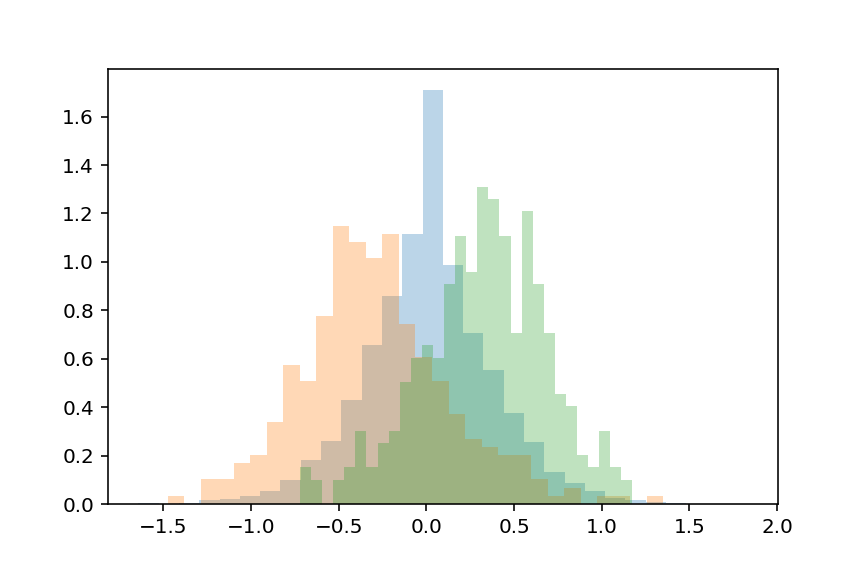

In [170]:
# Original: single left-right bins.

files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_left4.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_right4.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = X[labeled].copy()
y_train = y[labeled].copy()

plt.hist(x_train[y_train==0][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,2], density=True, bins=30, alpha=0.3);

<IPython.core.display.Javascript object>


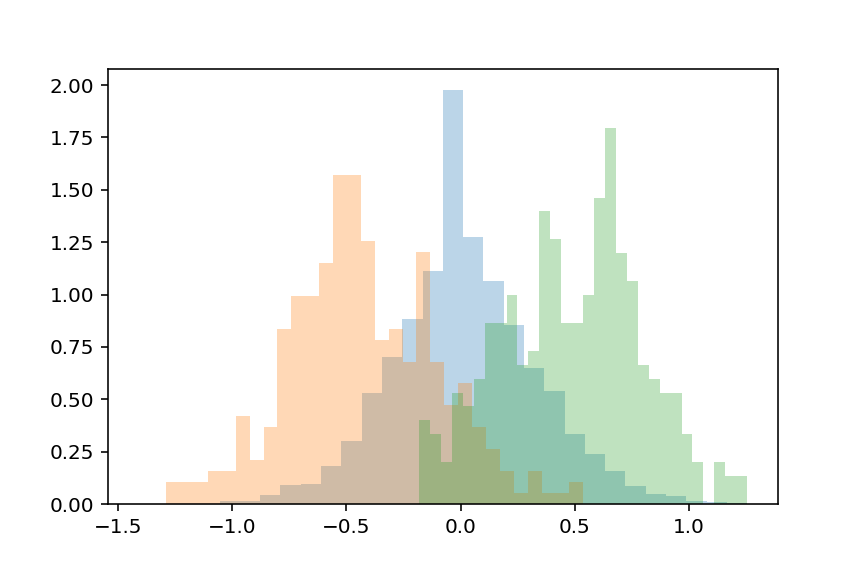

In [175]:
# Windows of 3.
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftwindow_3.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/rightwindow_3.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = X[labeled].copy()
y_train = y[labeled].copy()

plt.hist(x_train[y_train==0][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,2], density=True, bins=30, alpha=0.3);

<IPython.core.display.Javascript object>


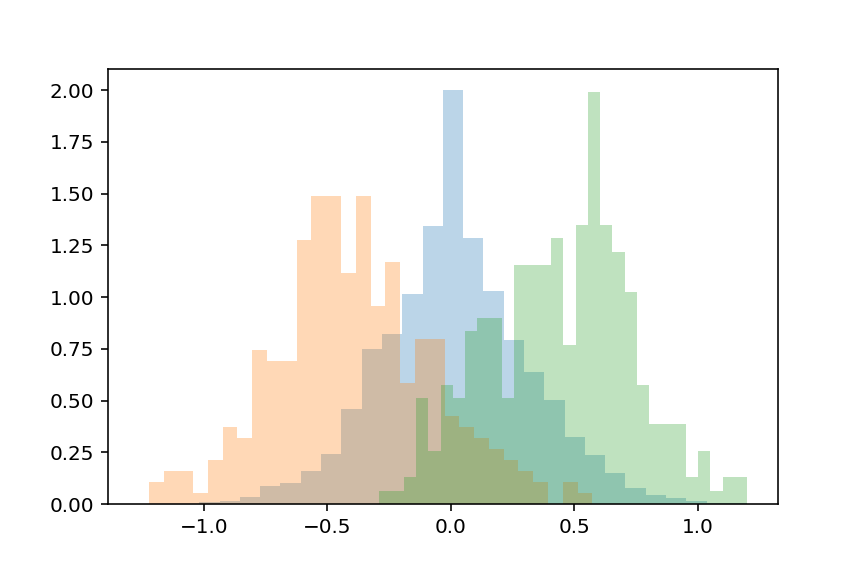

In [171]:
# Windows of 4
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftwindow_4.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/rightwindow_4.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = X[labeled].copy()
y_train = y[labeled].copy()

plt.hist(x_train[y_train==0][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,2], density=True, bins=30, alpha=0.3);

In [172]:
# Windows of 6.
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftwindow_6.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/rightwindow_6.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = X[labeled].copy()
y_train = y[labeled].copy()

<IPython.core.display.Javascript object>


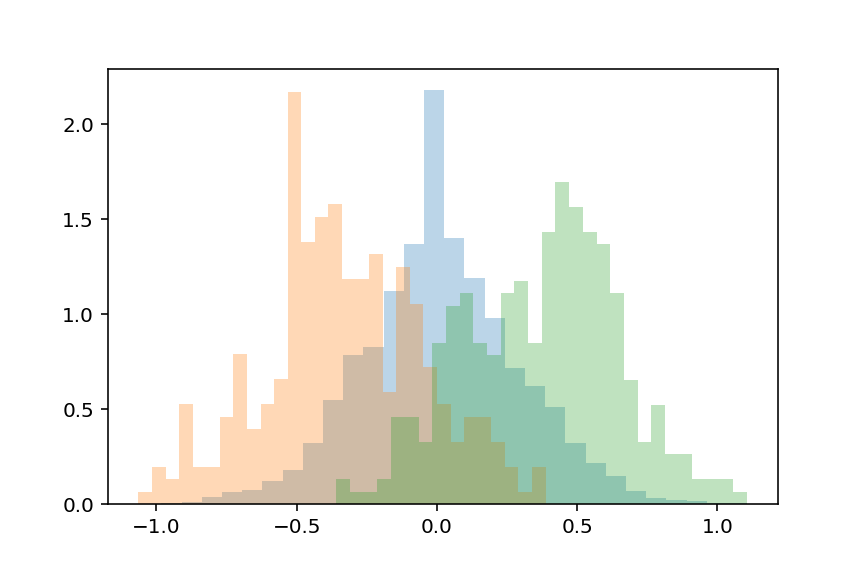

In [168]:
plt.hist(x_train[y_train==0][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,2], density=True, bins=30, alpha=0.3);

<IPython.core.display.Javascript object>


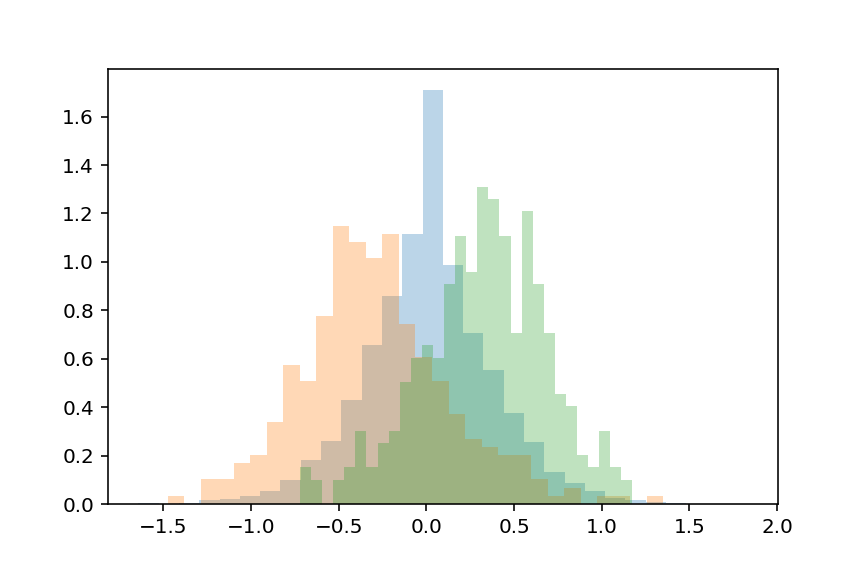

In [169]:
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_left4.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftright_right4.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = X[labeled].copy()
y_train = y[labeled].copy()

plt.hist(x_train[y_train==0][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,1], density=True, bins=30, alpha=0.3);
plt.hist(x_train[y_train==1][:,2], density=True, bins=30, alpha=0.3);

OK the windows seem to give better separation. I like window size 3.

In [213]:
# Windows of 3.
files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/insscore_v2.txt.gz',
        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/leftwindow_3.txt.gz',
         '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_tracks/rightwindow_3.txt.gz']
X = make_sample_data(files, 3e7)

c_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
y = labels_from_hand_calls(c_files, X[:,0], adjacent=4)
labeled = y != -1

x_train = normcol(X[labeled])
y_train = y[labeled]

<IPython.core.display.Javascript object>


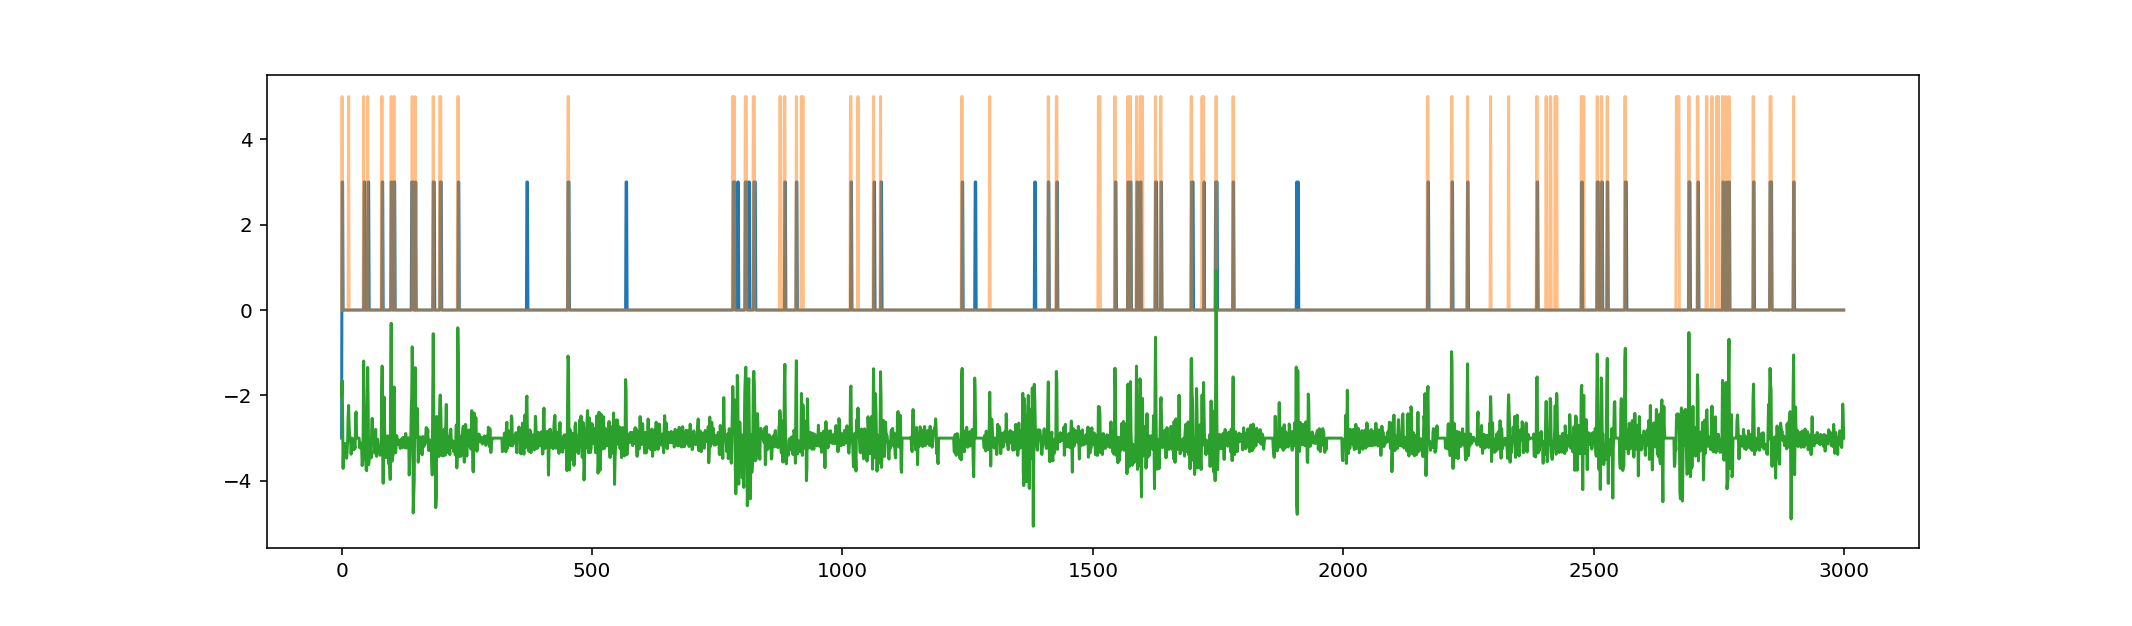

In [179]:
# Full model.
d_b = MultivariateGaussianDistribution.from_samples(x_train[y_train.astype(bool)])
d_nb = MultivariateGaussianDistribution.from_samples(x_train[~y_train.astype(bool)])

s_nb = State(d_nb, name='notboundary')
s_b = State(d_b, name='boundary')

model = HiddenMarkovModel()
model.add_states(s_b, s_nb)
model.add_transition(model.start, s_b, 0.5)
model.add_transition(model.start, s_nb, 0.5)
model.add_transition(s_nb, s_nb, 0.974 )
model.add_transition(s_nb, s_b, 0.026 )
#model.add_transition(s_b, model.end, 0.001)
model.add_transition(s_b, s_b, 0.34)
model.add_transition(s_b, s_nb, 0.66)
model.bake()

output = model.predict(x_train, algorithm='viterbi')
start=0
end=3000

plt.plot(flip(output)[start:end]*3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

<IPython.core.display.Javascript object>


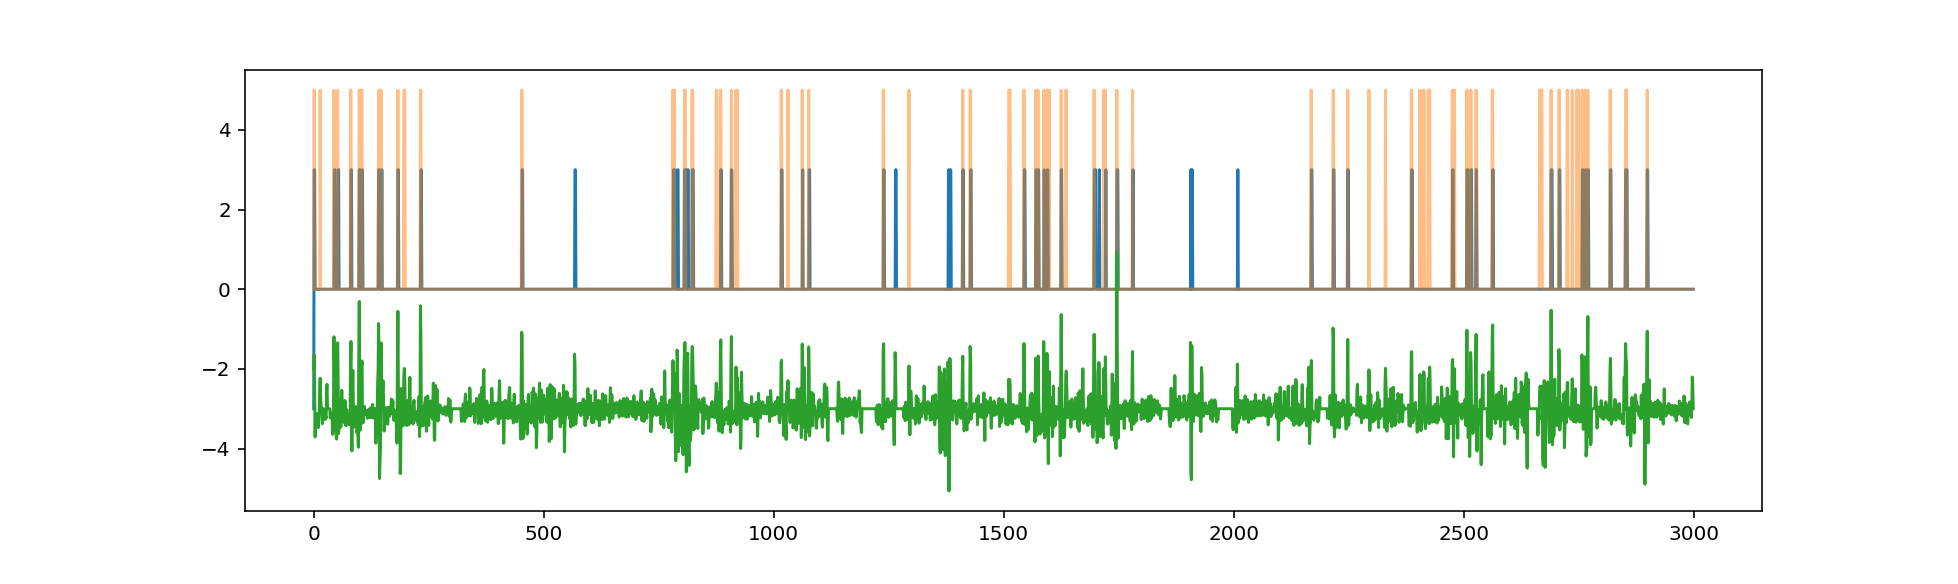

In [180]:
# Derivative alone.
d_b = NormalDistribution.from_samples(x_train[y_train.astype(bool)][:,0])
d_nb = NormalDistribution.from_samples(x_train[~y_train.astype(bool)][:,0])

s_nb = State(d_nb, name='notboundary')
s_b = State(d_b, name='boundary')

model = HiddenMarkovModel()
model.add_states(s_b, s_nb)
model.add_transition(model.start, s_b, 0.5)
model.add_transition(model.start, s_nb, 0.5)
model.add_transition(s_nb, s_nb, 0.974 )
model.add_transition(s_nb, s_b, 0.026 )
#model.add_transition(s_b, model.end, 0.001)
model.add_transition(s_b, s_b, 0.34)
model.add_transition(s_b, s_nb, 0.66)
model.bake()

output = model.predict(x_train[:,0], algorithm='viterbi')
start=0
end=3000

plt.plot(flip(output)[start:end]*3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

<IPython.core.display.Javascript object>


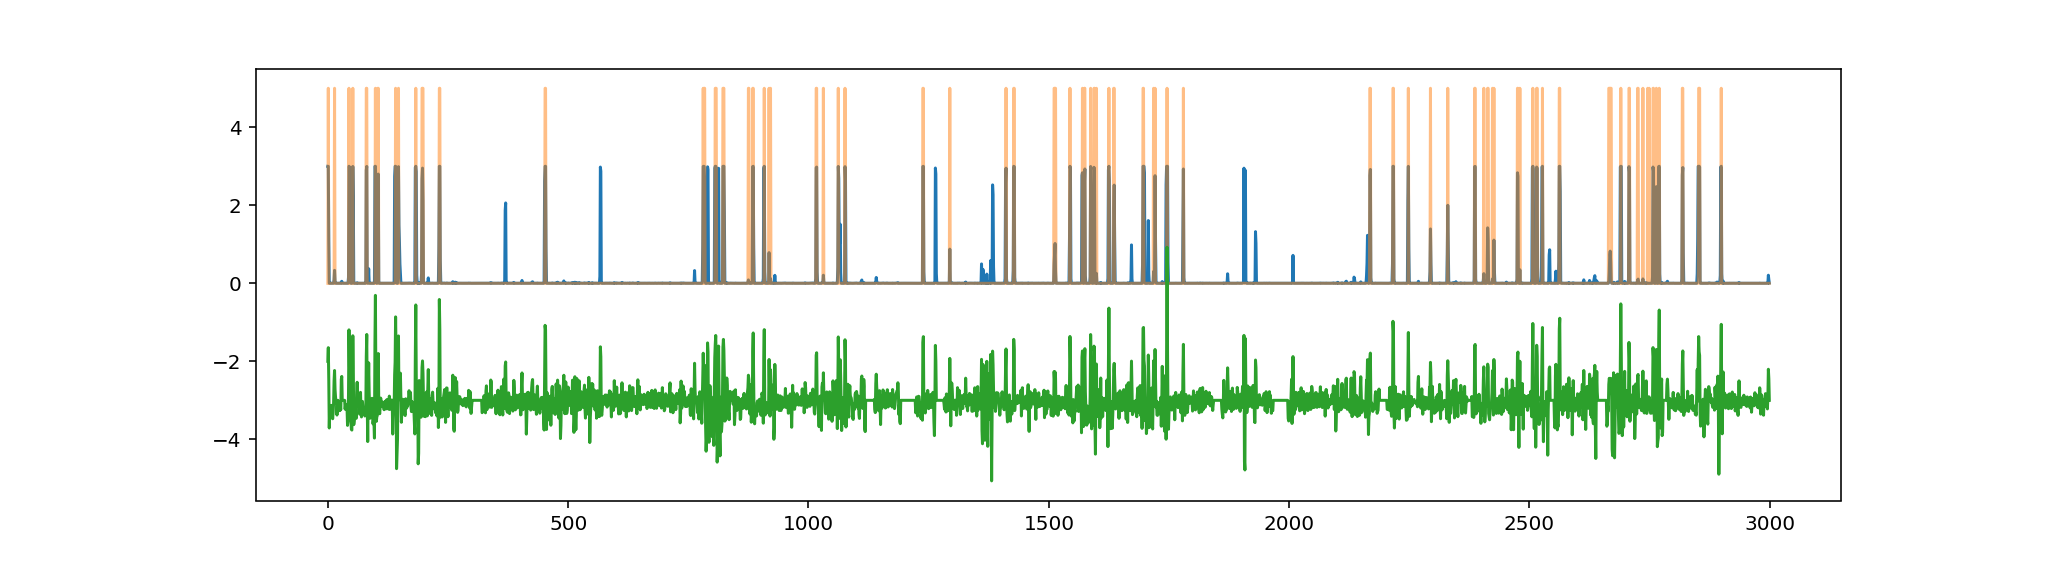

In [233]:
# What about probabilities?

d_b = MultivariateGaussianDistribution.from_samples(x_train[y_train.astype(bool)])
d_nb = MultivariateGaussianDistribution.from_samples(x_train[~y_train.astype(bool)])

s_nb = State(d_nb, name='notboundary')
s_b = State(d_b, name='boundary')

model = HiddenMarkovModel()
model.add_states(s_b, s_nb)
model.add_transition(model.start, s_b, 0.5)
model.add_transition(model.start, s_nb, 0.5)
model.add_transition(s_nb, s_nb, 0.974 )
model.add_transition(s_nb, s_b, 0.026 )
#model.add_transition(s_b, model.end, 0.001)
model.add_transition(s_b, s_b, 0.34)
model.add_transition(s_b, s_nb, 0.66)
model.bake()

output = model.predict_proba(x_train)
start=0
end=3000

plt.plot(output[:,0][start:end]*3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

## Getting better...

This is getting better and performing...ok? Still not great. An interesting implication of the boundary size discussion above is that one of the reasons I thought an HMM would be essential was that I (somewhat) expected boundaries to cover a few bins, and so capturing the sequence aspect of the data would be important (as opposed to treating bins as independent observations in a typical classifier). But this doesn't turn out to be right; the sequence information is probably dispensable for boundaries that cover 1-2 bins in the data. So it's worth trying some other classifiers, I think.

## Naive Bayes

<IPython.core.display.Javascript object>


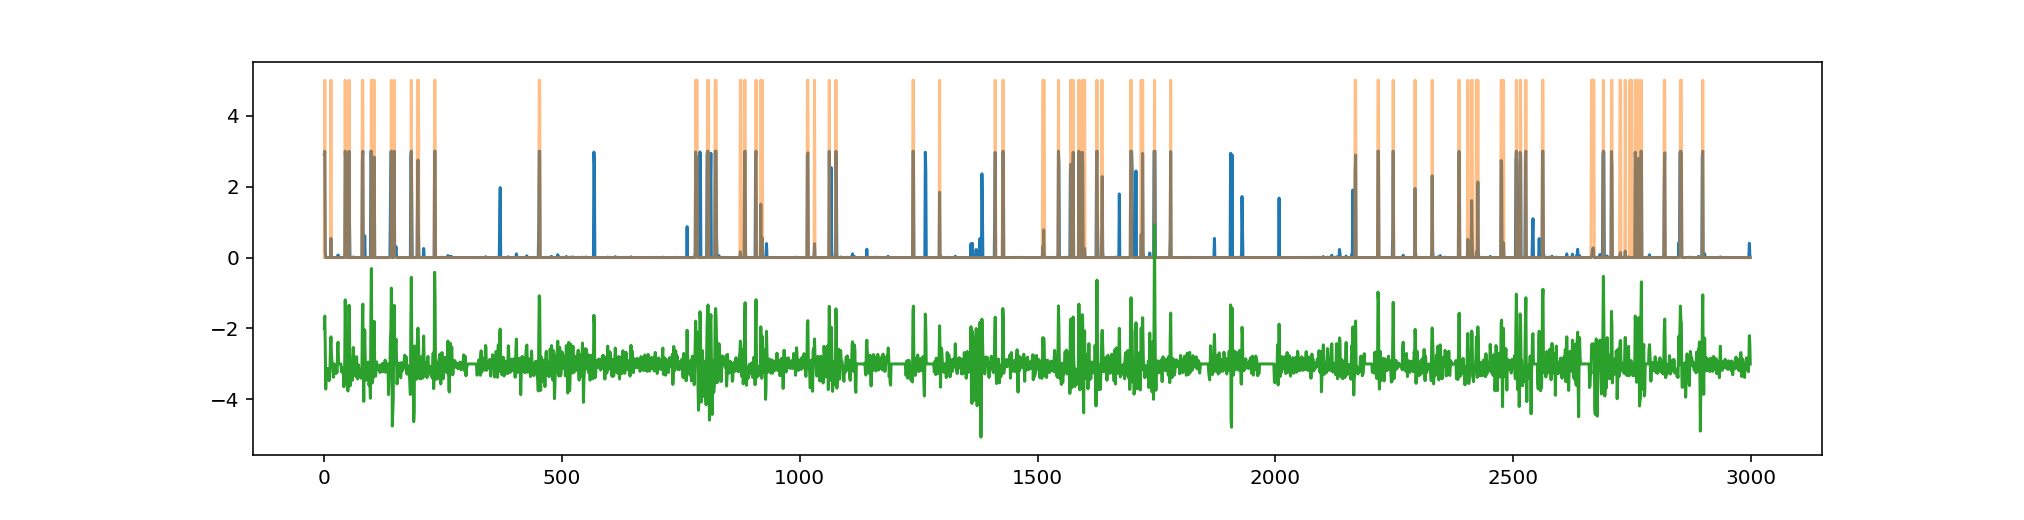

In [230]:
# Full model.
nbayes = NaiveBayes.from_samples(NormalDistribution, x_train, y_train)
output = nbayes.predict_proba(x_train)
start=0
end=3000

plt.plot(-1 * output[:,0][start:end]*3 + 3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

<IPython.core.display.Javascript object>


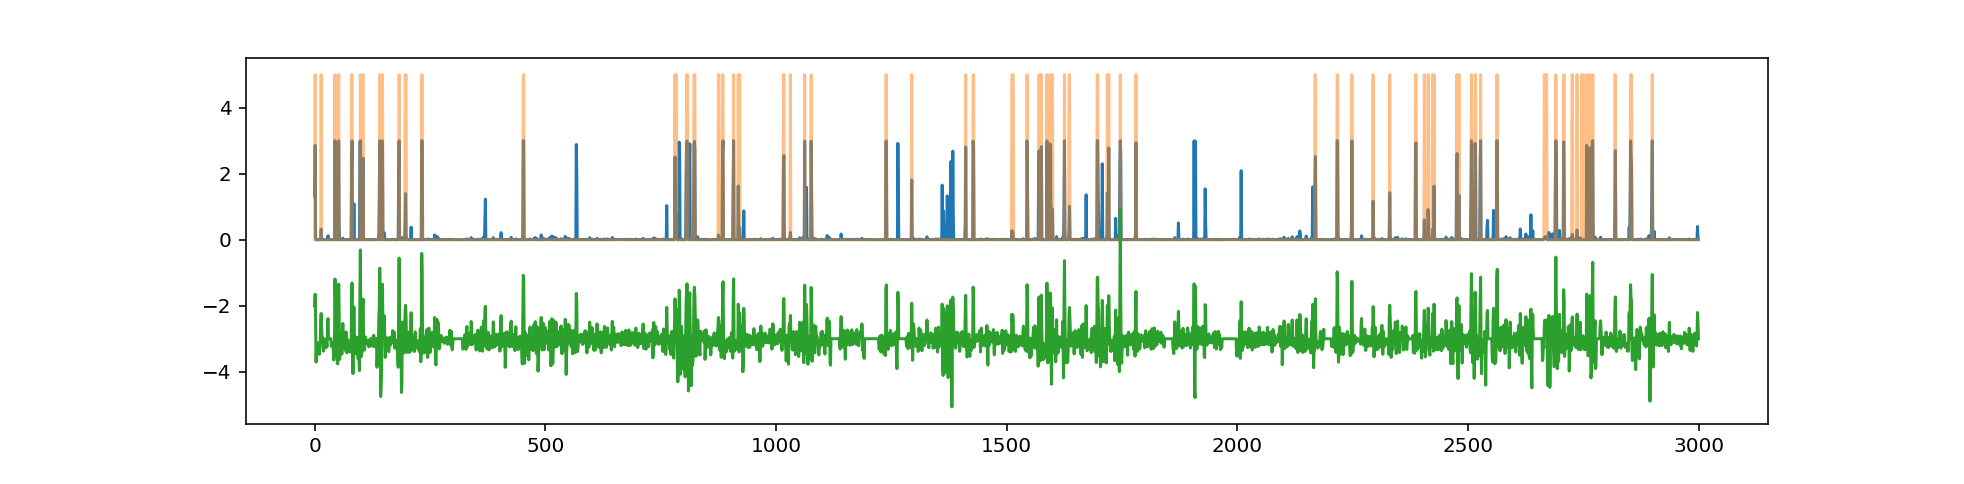

In [231]:
nbayes = NaiveBayes.from_samples(NormalDistribution, x_train[:,0:1], y_train)
output = nbayes.predict_proba(x_train[:,0:1])
start=0
end=3000

plt.plot(-1 * output[:,0][start:end]*3 + 3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

## General Bayes

<IPython.core.display.Javascript object>


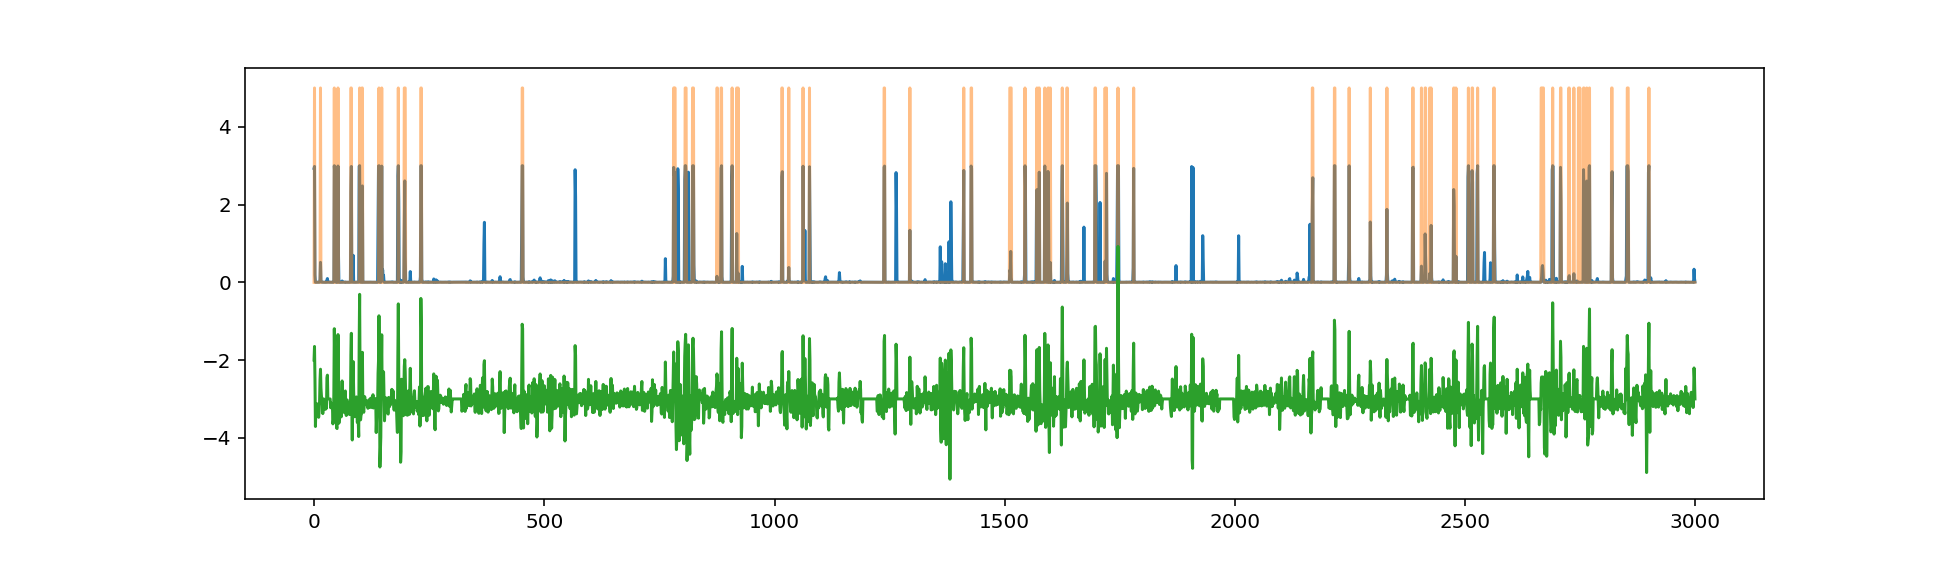

In [232]:
# Full model.
bayes = BayesClassifier.from_samples(MultivariateGaussianDistribution, x_train, y_train)
output = bayes.predict_proba(x_train)
start=0
end=3000

plt.plot(-1 * output[:,0][start:end]*3 + 3)
plt.plot(y_train[start:end] * 5, alpha=0.5)
plt.plot(x_train[:,0][start:end] * 0.5 - 3)

## Where are we?

So these classifiers work reasonably well. It would be good to actually look at some of these calls on the viewer to see what it's doing. I don't think the classifier will matter much with this few features -- the learning algorithms aren't gonna do much. The main advantage to using the algorithms is that it provides a platform to add more features (protein, etc.) to either classify boundaries or potentially other features. It's clear that they do a fine job of basically picking out peaks in the derivative. Unclear how much the left and right windows help, maybe a little. From this, it's clear that the issue is going to be, as always, the quality of the data going in. Calling boundaries from high-quality data will be trivial. 

So I think the focus needs to be on the input data, figuring out why we are missing some peaks and getting other spurious peaks. 

Going to start in a new notebook.